# 데이터 받아오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install haversine
!pip install reverse_geocoder
!pip uninstall umap
!pip install umap-learn -i https://mirrors.ustc.edu.cn/pypi/web/simple
!pip install catboost

# 분석
import math
from haversine import haversine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rg

%matplotlib inline

# 머신러닝
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
from sklearn.decomposition import PCA
import umap
import gc
import catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=f857fe992a9d6371c71c272a2263405452ea0a2c48a7713a1e25e800b3a36adc
  Stored in directory: /root/.cache/pip/wheels/65/42/5e/223fcd5dc869ff98d5ee6b19e236f82828e4e3c039328ebe20
Successfully built reverse_geocoder
Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


RuntimeError: ignored

In [ ]:
path = '/content/drive/MyDrive/SK_Rookies/모듈프로젝트2/data/'

train_path = f'{path}train.csv'
test_path = f'{path}test.csv'
sample_submission_path = f'{path}sample_submission.csv'

train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')
sample_submission = pd.read_csv(sample_submission_path)

In [ ]:
from sklearn.datasets import fetch_california_housing

add_data = fetch_california_housing()
add_data_frame = pd.DataFrame( add_data['data'] , columns= add_data['feature_names'])
add_data_frame['MedHouseVal']  = add_data['target']

add_data_frame['is_gen'] = 1
train['is_gen'] = 0
test['is_gen'] = 0

train = pd.concat( [ train, add_data_frame ] )

# 데이터 분석

In [ ]:
train.shape, test.shape

((57777, 10), (24759, 9))

In [ ]:
train.columns, test.columns

(Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
        'Latitude', 'Longitude', 'MedHouseVal', 'is_gen'],
       dtype='object'),
 Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
        'Latitude', 'Longitude', 'is_gen'],
       dtype='object'))

- MedHouseVal : 평균 집값
- MedInc : 평균 수입
- HouseAge : 집의 나이
- AveRooms : 전체 방의 평균 갯수
- AveBedrms : 침실의 평균 갯수
- Population : 인구
- AveOccup : 가족구성원의 평균 인원
- Latitude : 위도
- Longitude : 경도

```
# 코드로 형식 지정됨
```




 

In [ ]:
train.head(1).T

0
MedInc          2.385900
HouseAge       15.000000
AveRooms        3.827160
AveBedrms       1.112100
Population   1280.000000
AveOccup        2.486989
Latitude       34.600000
Longitude    -120.120000
MedHouseVal     0.980000
is_gen          0.000000

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57777 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       57777 non-null  float64
 1   HouseAge     57777 non-null  float64
 2   AveRooms     57777 non-null  float64
 3   AveBedrms    57777 non-null  float64
 4   Population   57777 non-null  float64
 5   AveOccup     57777 non-null  float64
 6   Latitude     57777 non-null  float64
 7   Longitude    57777 non-null  float64
 8   MedHouseVal  57777 non-null  float64
 9   is_gen       57777 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 4.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24759 entries, 37137 to 61895
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      24759 non-null  float64
 1   HouseAge    24759 non-null  float64
 2   AveRooms    24759 non-null  float64
 3   AveBedrms   247

(None, None)

In [ ]:
cols = list(train.columns)
cols.pop(-1)
cols

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'MedHouseVal']

In [ ]:
def data_visualizer(data, features, mode='hist'):
    '''
    mode: 'hist' or 'reg' , 'heat'
    '''

    if mode == 'heat':
        sns.heatmap( data[ features ].corr(), annot=True );
        return 0

    cols = 2
    rows = math.ceil(len(features) / cols )

    fig, ax = plt.subplots( ncols=cols, nrows=rows, figsize=(15,20) )

    if mode == 'hist':
        for i, feature in enumerate(features):
            sns.distplot(data[feature], ax=ax[math.floor(i/cols)][i%cols]);
    
    elif mode == 'reg':
        for i, feature in enumerate(features):
            sns.regplot(data=data, x = feature,y='MedHouseVal' ,ax=ax[math.floor(i/cols)][i%cols], line_kws={'color':'red'}, scatter_kws={'alpha':0.5});
    
    else:
        pass

    plt.show()

    return 0

## 히스토그램

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

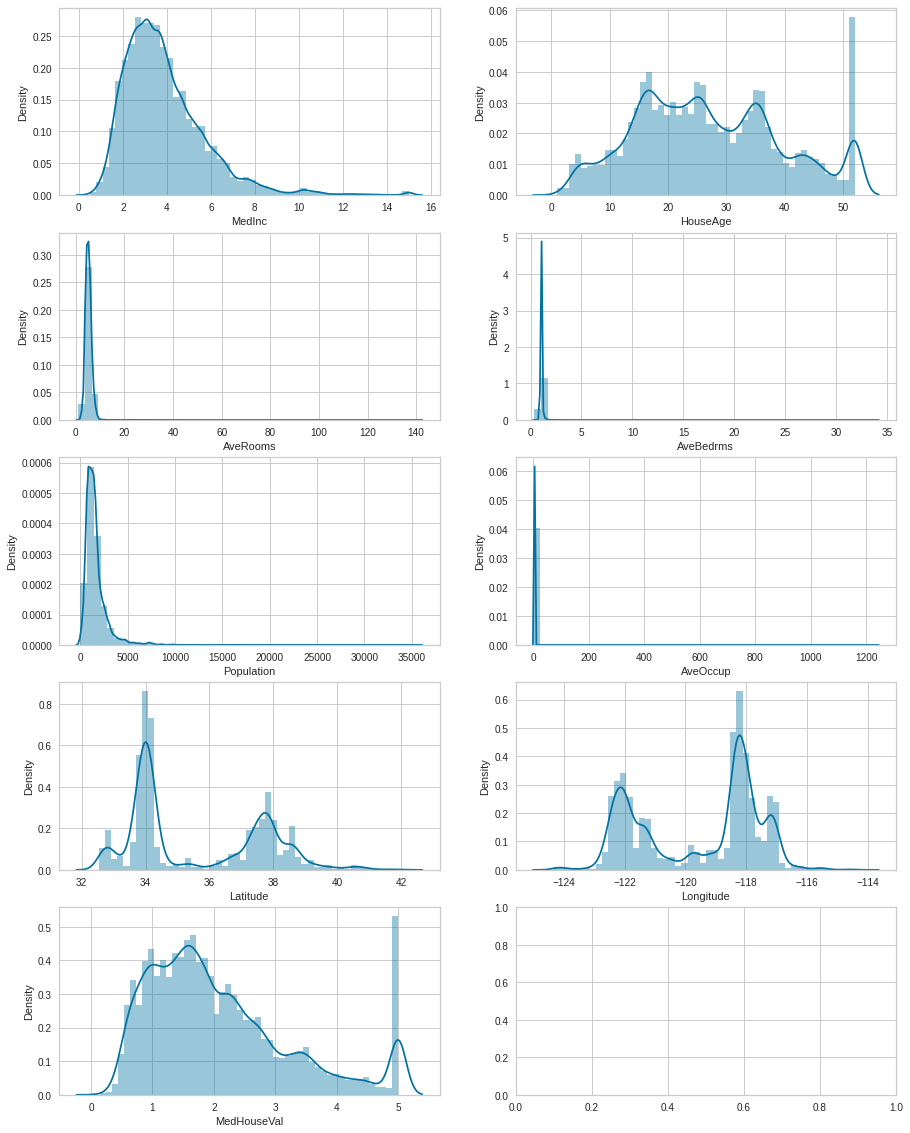

0

In [ ]:
data_visualizer(train, cols, mode='hist')

## 회귀

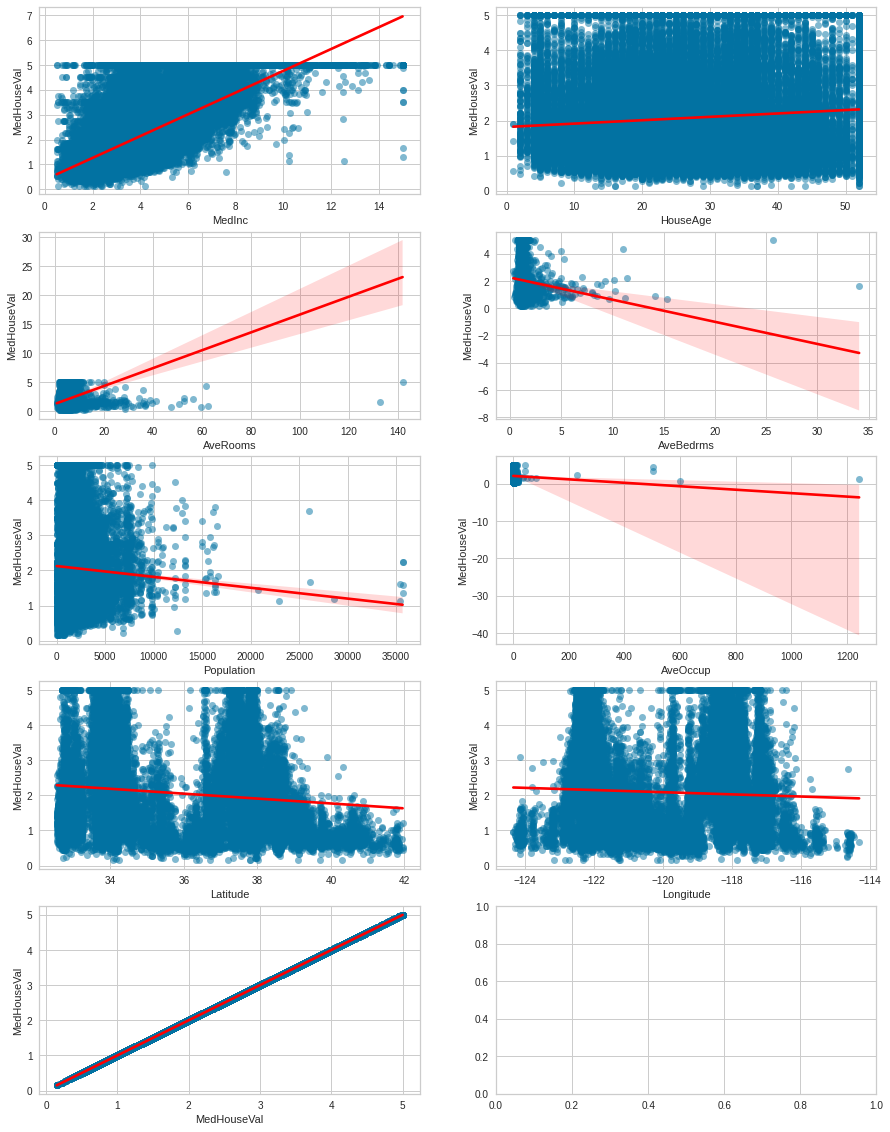

0

In [ ]:
data_visualizer(train, cols, mode='reg')

## 히트맵

0

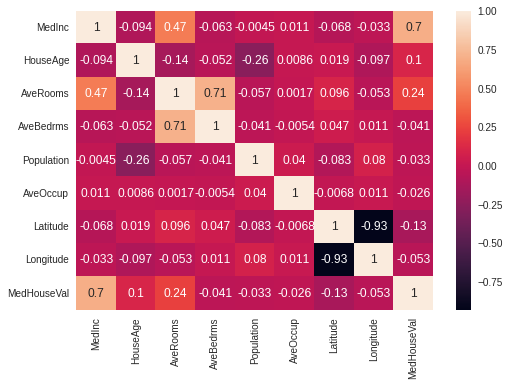

In [ ]:
data_visualizer(train, cols, mode='heat')

## 위경도

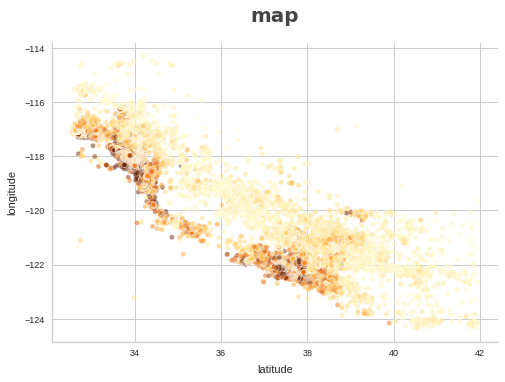

In [ ]:
#이차원 밀집도 그리기
def map_visualizer(data, lat, lng):

    plt.title('map', size=20, y=1.05, fontname='Calibri', 
            fontweight='bold', color='#444444')
    a = sns.scatterplot(data=data, x=lat, y=lng, hue='MedHouseVal', 
                        palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel('latitude', labelpad=7, fontsize=11)
    plt.ylabel('longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()
    
    plt.show()

map_visualizer(train, 'Latitude', 'Longitude')

## 결론

- 이상치 제거
    - MedInc
    - AveRooms
    - AveBedrms
    - Population
    - AveOccup

- 차원 정리
    - Latitude
    - Longitude 

- 강한 상관관계
    - 양
        -  AveRooms & MedInc
            - 하나만 사용 
                - (다른 팩터들과 AveRooms의 상관관계가 살짝 높음)
            - 둘다 사용
    - 음 
        - Latitude & Longitude (차원 정리)



# 데이터 처리

In [ ]:
# 이상치 제거 함수
def remove_outlier(data, cols, rev_range):

    start = data.shape        

    for idx, col in enumerate(cols):
        
        ori = data.shape

        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        data = data[ ( data[col] <= Q3 + (rev_range[idx] * IQR) ) & ( data[col] >= Q1 - (rev_range[idx] * IQR) ) ]

        data.reset_index(drop=True, inplace=True)

        print(f'{ori} -> {data.shape}, rev_range: {rev_range[idx]},  del: {ori[0] - data.shape[0]}')

    print(f'total del: {start[0] - data.shape[0]}')
    
    return data

- MedInc : 이상치 제거, 상관관계 상쇄 1
- HouseAge : 데이터 분포 범위를 정해서 범주화
- AveRooms : 이상치 제거, 상관관계 상쇄 1
- AveBedrms : 이상치 제거
- Population : 이상치 제거
- AveOccup : 이상치 제거
- Latitude : 차원 축소, 상관관계 상쇄 2
- Longitude : 차원축소, 상관관계 상쇄 2


## 이상치 제거

- 제거한 결과 데이터 프레임 : tmp

(57777, 10) -> (57621, 10), rev_range: 4,  del: 156
(57621, 10) -> (57484, 10), rev_range: 5,  del: 137
(57484, 10) -> (56917, 10), rev_range: 5,  del: 567
(56917, 10) -> (56853, 10), rev_range: 10,  del: 64
(56853, 10) -> (56780, 10), rev_range: 6,  del: 73
total del: 997


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

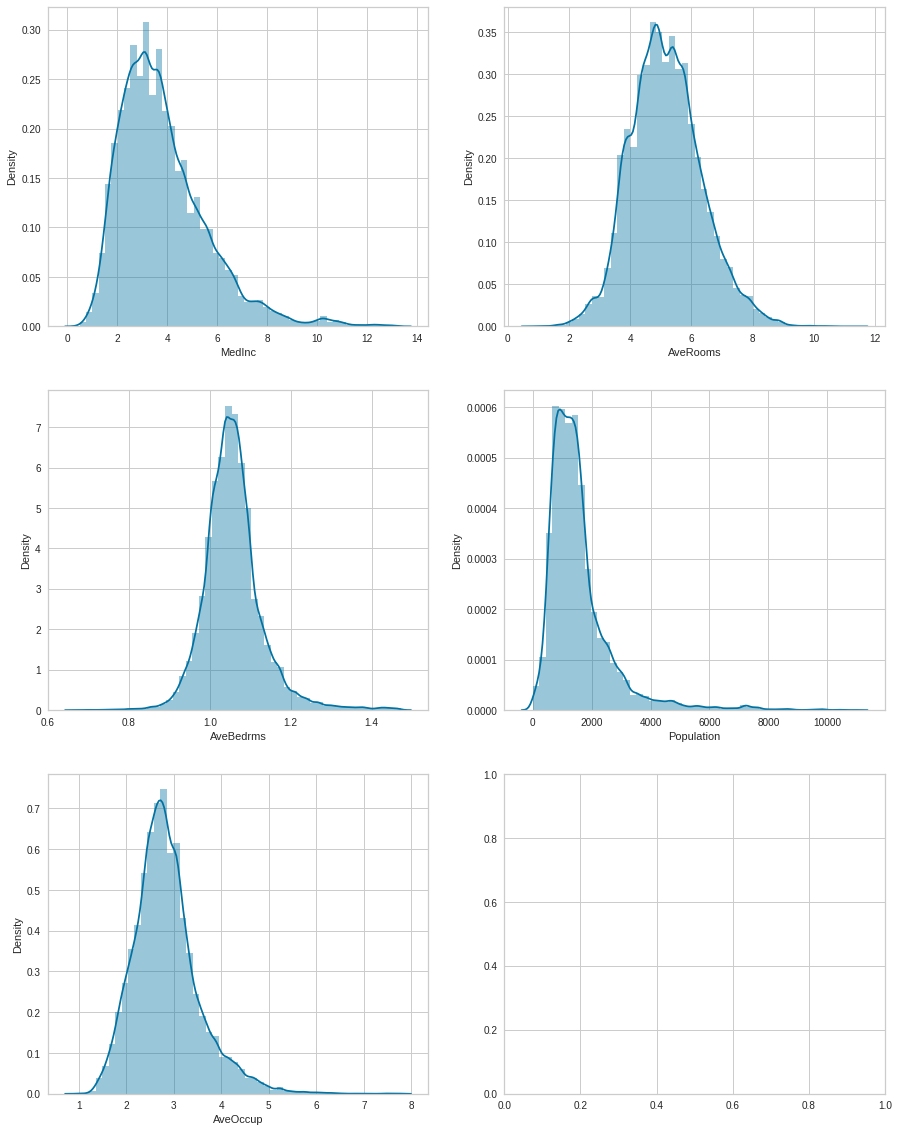

0

In [ ]:
remove_outlier_list =   ['MedInc',  'AveRooms',     'AveBedrms',    'Population',   'AveOccup']
remove_outlier_rev =    [4,       5,            5,            10,             6]

tmp = remove_outlier(train, remove_outlier_list, remove_outlier_rev)
data_visualizer(tmp, remove_outlier_list, mode='hist')

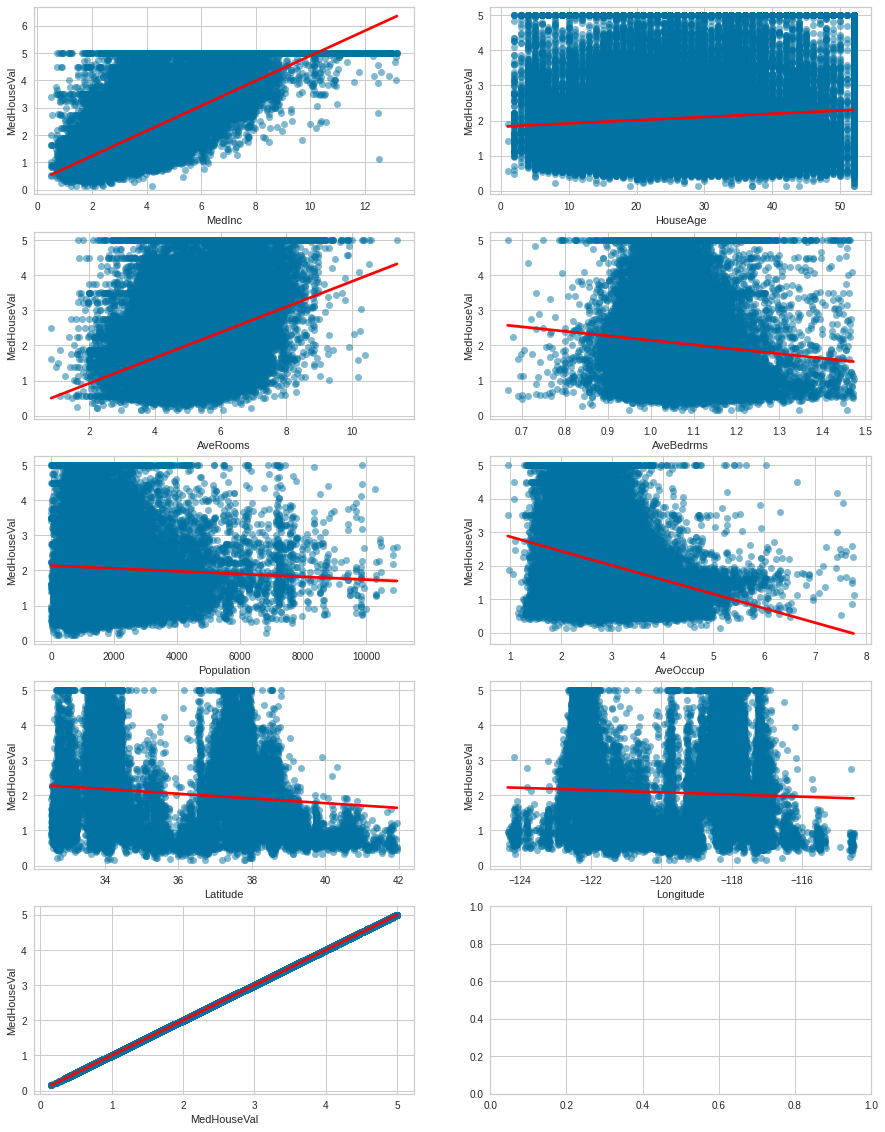

0

In [ ]:
data_visualizer(tmp, cols, mode='reg')

## 상관관계 상쇄

- MedInc & AveRooms 
- Latitude & Longitude

|df|MedInc|AveRooms|Latitude|Longitude|
|--|--|--|--|--|
|tmp1|o|x|o|x|
|tmp2|o|x|x|o|
|tmp3|x|o|o|x|
|tmp4|x|o|x|o|
|tmp_D_1|o|x|o|o|
|tmp_D_2|x|o|o|o|

- tmp 1 ~ 4 : 차원 축소 할 필요 없음
- tmp_D_1 ~ 2 : 차원축소 필요

- 상관관계를 상쇄하였을 경우 오히려 점수가 떨어짐


In [ ]:
tmp1 = tmp.drop(columns=['AveRooms', 'Longitude'])
tmp2 = tmp.drop(columns=['AveRooms', 'Latitude'])
tmp3 = tmp.drop(columns=['MedInc', 'Longitude'])
tmp4 = tmp.drop(columns=['MedInc', 'Latitude'])

test1 = test.drop(columns=['AveRooms', 'Longitude'])
test2 = test.drop(columns=['AveRooms', 'Latitude'])
test3 = test.drop(columns=['MedInc', 'Longitude'])
test4 = test.drop(columns=['MedInc', 'Latitude'])

####

tmp_D_1 = tmp.drop(columns=['MedInc'])
tmp_D_2 = tmp.drop(columns=['AveRooms'])

test_D_1 = test.drop(columns=['MedInc'])
test_D_2 = test.drop(columns=['AveRooms'])

In [ ]:
tmp1.shape, test1.shape

((56780, 8), (24759, 7))

## 위경도를 이용하여 새로운 피쳐 생성

- Latitude
- Longitude

- 거리계산
    - 유클리드 거리
    - 하버 사인 거리(비유클리드적 거리)
    - 편집거리 ()
    - 멘해튼 거리 (유클리드적 공간에 격자형 길만을 이용해 움직이는 거리)

- 범주화
    - 지오코드를 이용하여 각각의 위경도 값을 지역으로 범주화
    - K-Mean을 이용하여 군집화 시킨뒤 범주화
    - 범주화 이후 단순 원-핫 인코딩 사용

- 분류
    - KNN을 이용하여 범주화



In [ ]:
# 위경도만 사용하기 쉽게 따로 추출

coordinates_train = tmp[['Latitude', 'Longitude']].values
coordinates_test = test[['Latitude', 'Longitude']].values

- 거리계산 알고리즘들


- 유클리드 거리
- 하버 사인 거리(비유클리드적 거리)
- 편집거리
- 멘해튼 거리 (유클리드적 공간에 격자형 길만을 이용해 움직이는 거리)

In [ ]:
# 유클리드 거리
def euclidean(lat1, long1, lat2, long2):
    return ( ( (lat1 - lat2) ** 2 ) + ( ( long1 - long2 ) ** 2 ) ) ** 0.5

# 맨해튼 거리
def manhattan(lat1, long1, lat2, long2):
    return abs(lat1 - lat2) + abs(long1 - long2)

# test
lat1, long1 = 37.541, 126.986
lat2, long2 = 43.65, -79.38

print(euclidean(lat1, long1, lat2, long2))
print(manhattan(lat1, long1, lat2, long2))
print(haversine((lat1, long1), (lat2, long2 )))

206.45640178255553
212.475
10603.855192138562


### 방법1 - 지역 분할

- 좌표평면 위의 지역을 지수함수를 이용하여 분할한 뒤 각 지역별 거리를 이용 

In [ ]:
emb_size = 20
precision = 1e6

latlon_train = np.expand_dims(coordinates_train, axis=-1) 
latlon_test = np.expand_dims(coordinates_test, axis=-1) 


# m 값은 e^(6/20)
m = np.exp(np.log(precision) / emb_size) 


# 1~20 까지 지수형태로 저장
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1, 1, emb_size) 


# 위도와 경도값에 각각 코사인 사인값을 취해주어 좀 더 정확한 결과가 나올 수 있도록 스케일링
# 1위 사용자가 사용한 Trick
latlon_train = latlon_train * angle_freq
latlon_train[..., 0::2] = np.cos(latlon_train[..., 0::2]) 
latlon_train[..., 1::2] = np.sin(latlon_train[..., 1::2]) 
latlon_train = latlon_train.reshape(-1, 2 * emb_size) 

latlon_test = latlon_test * angle_freq
latlon_test[..., 0::2] = np.cos(latlon_test[..., 0::2]) 
latlon_test[..., 1::2] = np.sin(latlon_test[..., 1::2]) 
latlon_test = latlon_test.reshape(-1, 2 * emb_size) 


# 피쳐 추가
tmp['l1'] = [ lat[0] for lat in latlon_train ]
tmp['l2'] = [ lat[1] for lat in latlon_train ]

test['l1'] = [ lat[0] for lat in latlon_test ]
test['l2'] = [ lat[1] for lat in latlon_test ]

### 방법 2 - K-Means

- 1) K-means를 이용하여 데이터를 범주화
- 2) 본인의 값과 각각의 범주의 중심의 거리를 새로운 피쳐로 이용


- 최적의 군집 갯수 찾기

- 방법1) 눈으로로 보았을때의의 갯수로 사용
    - 위경도 이므로 단순 밀집으로 분류하는 군집 갯수는 의미가 없을 수 도 있음
    - 3개의 집단

- 방법2) 메타적인 데이터를 사용하여 분류
    - 위도 경도를 이용하여 파악한 지역의 갯수를 이용 
        - 15개의 지역이 존재함 뭔가 연관이 있을까?
        - 반올림하여 20개 사용

- 방법3) 단순히 많은 값을 사용 (X)
    - 50개 정도의 군집을 사용해 보자 -> 너무 많기에 오래걸림



In [ ]:
# 군집 분류 -> 3개
clustering = KMeans(n_clusters=3, max_iter=2000, random_state=0)
clustering.fit(coordinates_train)

# 각 군집의 중앙값과 각 데이터의 위경도 값의 거리 계산
# 1. 각각의 군집의 중앙값 정의
centers = {}
for idx, center_latlng in enumerate(clustering.cluster_centers_):
    centers[idx] = tuple(center_latlng)

print(centers)


# 2. 군집의 중심과 위경도 값의 거리계산 함수 (유클리드 공간이므로 havesine 방식 사용)
def calculate_dist_to_center(data, centers):
    result = {}
    for idx in centers:
        center_latlng = centers[idx]
        result[idx] = data.apply(lambda x : haversine( (x['Latitude'], x['Longitude']), 
                                                      center_latlng, unit='ft'), axis=1)

    return result

# 3. 거리 계산
res_train = calculate_dist_to_center(tmp, centers)
res_test = calculate_dist_to_center(test, centers)
    
for idx in res_train:
    tmp[f'cluster_3_{idx}'] = res_train[idx]

for idx in res_test:
    test[f'cluster_3_{idx}'] = res_test[idx]

{0: (36.022912221144516, -119.7002546071775), 1: (33.83380649596209, -117.9214619920523), 2: (38.042609080738416, -121.92566194294237)}


In [ ]:
# 군집 분류 -> 20개
clustering = KMeans(n_clusters=20, max_iter=1111, random_state=228)
clustering.fit(coordinates_train)

# 각 군집의 중앙값과 각 데이터의 위경도 값의 거리 계산
# 1. 각각의 군집의 중앙값 정의
centers = {}
for idx, center_latlng in enumerate(clustering.cluster_centers_):
    centers[idx] = tuple(center_latlng)

print(centers)

# 2. 거리 계산
res_train = calculate_dist_to_center(tmp, centers)
res_test = calculate_dist_to_center(test, centers)


for idx in res_train:
    tmp[f'cluster_20_{idx}'] = res_train[idx]

for idx in res_test:
    test[f'cluster_20_{idx}'] = res_test[idx]

{0: (33.95718843572535, -118.1919081053175), 1: (38.01035004321521, -122.02441659464131), 2: (32.856391541609824, -117.11712141882674), 3: (36.63836231884058, -119.6507729468599), 4: (38.631110105580696, -121.33167420814479), 5: (40.77885521885521, -124.05444444444444), 6: (34.314625121713725, -119.33935735150925), 7: (40.614444444444445, -122.2624171539961), 8: (37.240183709606015, -121.92291500664011), 9: (34.06430191124068, -117.29385163589245), 10: (37.74966672059537, -122.32312085423071), 11: (35.07204262877442, -120.55326820603908), 12: (35.51176530612245, -118.92154081632653), 13: (37.55408981555733, -120.78583801122694), 14: (37.97394440270473, -121.29173553719008), 15: (34.15556139852189, -118.419823763502), 16: (33.50337545126354, -115.91895306859206), 17: (33.81216826262982, -117.8612497799683), 18: (39.46420944558522, -121.49894250513347), 19: (38.56347869177404, -122.7400396432111)}


### 방법 3 - 차원축소






#### 방법 3-1-1  PCA

In [ ]:
from sklearn.decomposition import PCA

pca_transformer = PCA().fit(coordinates_train)


tmp['pca_lat'] = pca_transformer.transform(coordinates_train)[:,0]
tmp['pca_lon'] = pca_transformer.transform(coordinates_train)[:,1]

test['pca_lat'] = pca_transformer.transform(coordinates_test)[:,0]
test['pca_lon'] = pca_transformer.transform(coordinates_test)[:,1]

#### 방법 3-1-2 PCA을 군집화

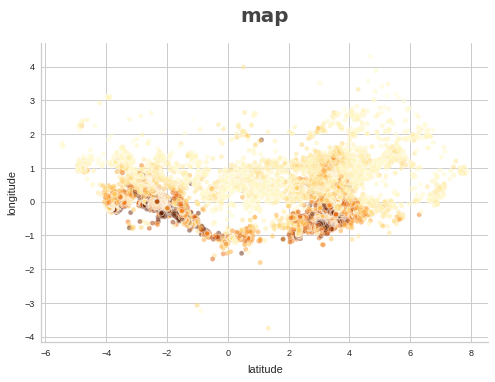

In [ ]:
map_visualizer(tmp, 'pca_lat', 'pca_lon')

In [ ]:
# 기존 위경도와 비슷한 모양을 가지므로 15 로 조정

coordinates_pca_train = tmp[['pca_lat', 'pca_lon']].values

clustering = KMeans(n_clusters=15, max_iter=2000, random_state=0)
clustering.fit(coordinates_train)

centers = {}
for idx, center_latlng in enumerate(clustering.cluster_centers_):
    centers[idx] = tuple(center_latlng)

print(centers)

def calculate_dist_to_center(data, centers):
    result = {}
    for idx in centers:
        center_latlng = centers[idx]
        result[idx] = data.apply(lambda x : haversine( (x['pca_lat'], x['pca_lon']), center_latlng, unit='ft'), axis=1)

    return result


res_train = calculate_dist_to_center(tmp, centers)
res_test = calculate_dist_to_center(test, centers)


for idx in res_train:
    tmp[f'pca_cluster_{idx}'] = res_train[idx]

for idx in res_test:
    test[f'pca_cluster_{idx}'] = res_test[idx]

{0: (36.65621442125237, -119.67890417457305), 1: (34.0938413411406, -118.39774925804123), 2: (38.52717627401838, -122.66610693400168), 3: (32.856537849511255, -117.11702432370994), 4: (37.78838087585375, -121.05118119726797), 5: (38.72965371200797, -121.35878923766815), 6: (40.304194711538464, -122.00693509615384), 7: (34.79329004329004, -120.21047619047619), 8: (37.81039157739193, -122.24788080285678), 9: (34.060002990430625, -117.31935705741627), 10: (37.24918693982074, -121.92045667947076), 11: (35.52467059980334, -118.92668633235004), 12: (33.864182689140755, -117.98842390777874), 13: (33.501379310344824, -115.91546279491833), 14: (40.76603896103896, -124.02613636363637)}


#### 방법 3-2 - umap

In [ ]:
umap_transformer = umap.umap_.UMAP(n_components=2, 
            n_neighbors=50, 
            random_state=228).fit(coordinates_train)


tmp['umap_lat'] = umap_transformer.transform(coordinates_train)[:,0]
tmp['umap_lon'] = umap_transformer.transform(coordinates_train)[:,1]

test['umap_lat'] = umap_transformer.transform(coordinates_test)[:,0]
test['umap_lon'] = umap_transformer.transform(coordinates_test)[:,1]

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### 방법 3-2-2 umap을 군집화

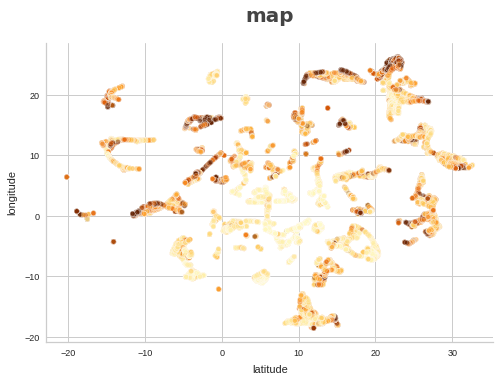

In [ ]:
map_visualizer(tmp, 'umap_lat', 'umap_lon')

In [ ]:
# 눈으로 보았을 때 약 20개의 군집이 보이므로 20으로 사용
coordinates_umap_train = tmp[['umap_lat', 'umap_lon']].values
coordinates_umap_test = test[['umap_lat', 'umap_lon']].values


clustering = KMeans(n_clusters=20, max_iter=2000, random_state=0)
clustering.fit(coordinates_umap_train)

centers = {}
for idx, center_latlng in enumerate(clustering.cluster_centers_):
    centers[idx] = tuple(center_latlng)

print(centers)

def calculate_dist_to_center(data, centers):
    result = {}
    for idx in centers:
        center_latlng = centers[idx]
        result[idx] = data.apply(lambda x : haversine( (x['umap_lat'], x['umap_lon']), center_latlng, unit='ft'), axis=1)

    return result

res_train = calculate_dist_to_center(tmp, centers)
res_test = calculate_dist_to_center(test, centers)

for idx in res_train:
    tmp[f'umap_cluster_{idx}'] = res_train[idx]

for idx in res_test:
    test[f'umap_cluster_{idx}'] = res_test[idx]

{0: (5.042679, 9.285443), 1: (29.615864, 8.729162), 2: (3.3097625, 0.3914919), 3: (22.869328, 21.503815), 4: (17.806013, -3.6500711), 5: (-13.433617, 10.687912), 6: (11.629941, -16.640207), 7: (-9.200098, 1.1981688), 8: (26.439224, -0.00766325), 9: (-1.542242, 18.619938), 10: (14.868639, 23.082787), 11: (16.411373, 7.007189), 12: (-4.154871, -7.2136087), 13: (10.385104, -0.20968199), 14: (11.817506, 15.363965), 15: (-14.346819, 19.66094), 16: (25.173853, 13.403455), 17: (-1.8340206, 7.54649), 18: (13.619363, -9.040724), 19: (5.474244, -8.290673)}


### 방법 4 - 해안가와의 거리

In [ ]:
from shapely.geometry import LineString, Point

coast_points = LineString([(32.664, -117.161), (33.206, -117.383),
                           (33.777, -118.202), (34.463, -120.014),
                           (35.427, -120.881), (35.928, -121.489),
                           (36.982, -122.028), (37.611, -122.491),
                           (38.355, -123.060), (39.792, -123.821),
                           (40.799, -124.188), (41.755, -124.197)])

tmp['dist_to_coast'] = tmp.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)
test['dist_to_coast'] = test.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)

### 방법 5 - 주요 도시와의 거리

In [ ]:
SC = (38.576931, -121.494949)
SF = (37.780080, -122.420160)
SJ = (37.334789, -121.888138)
LA = (34.052235, -118.243683)
SD = (32.715759, -117.163818)

tmp['dist_SC'] = tmp.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SC, unit='ft'), axis=1)
tmp['dist_SF'] = tmp.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SF, unit='ft'), axis=1)
tmp['dist_SJ'] = tmp.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SJ, unit='ft'), axis=1)
tmp['dist_LA'] = tmp.apply(lambda x: haversine((x['Latitude'], x['Longitude']), LA, unit='ft'), axis=1)
tmp['dist_SD'] = tmp.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SD, unit='ft'), axis=1)
tmp['dist_nearest_city'] = tmp[['dist_SC', 'dist_SF', 'dist_SJ', 'dist_LA', 'dist_SD']].min(axis=1)


test['dist_SC'] = test.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SC, unit='ft'), axis=1)
test['dist_SF'] = test.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SF, unit='ft'), axis=1)
test['dist_SJ'] = test.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SJ, unit='ft'), axis=1)
test['dist_LA'] = test.apply(lambda x: haversine((x['Latitude'], x['Longitude']), LA, unit='ft'), axis=1)
test['dist_SD'] = test.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SD, unit='ft'), axis=1)
test['dist_nearest_city'] = test[['dist_SC', 'dist_SF', 'dist_SJ', 'dist_LA', 'dist_SD']].min(axis=1)

### 방법 6 - 위도 경도 회전

- 회전시킨 위도 경도를 새로운 피쳐로 이용하여여 사용

In [ ]:
tmp['rot_15_x'] = (np.cos(np.radians(15)) * tmp['Longitude']) + \
                  (np.sin(np.radians(15)) * tmp['Latitude'])
    
tmp['rot_15_y'] = (np.cos(np.radians(15)) * tmp['Latitude']) + \
                  (np.sin(np.radians(15)) * tmp['Longitude'])
    
tmp['rot_30_x'] = (np.cos(np.radians(30)) * tmp['Longitude']) + \
                  (np.sin(np.radians(30)) * tmp['Latitude'])
    
tmp['rot_30_y'] = (np.cos(np.radians(30)) * tmp['Latitude']) + \
                  (np.sin(np.radians(30)) * tmp['Longitude'])
    
tmp['rot_45_x'] = (np.cos(np.radians(44)) * tmp['Longitude']) + \
                  (np.sin(np.radians(45)) * tmp['Latitude'])

In [ ]:
test['rot_15_x'] = (np.cos(np.radians(15)) * test['Longitude']) + \
                  (np.sin(np.radians(15)) * test['Latitude'])
    
test['rot_15_y'] = (np.cos(np.radians(15)) * test['Latitude']) + \
                  (np.sin(np.radians(15)) * test['Longitude'])
    
test['rot_30_x'] = (np.cos(np.radians(30)) * test['Longitude']) + \
                  (np.sin(np.radians(30)) * test['Latitude'])
    
test['rot_30_y'] = (np.cos(np.radians(30)) * test['Latitude']) + \
                  (np.sin(np.radians(30)) * test['Longitude'])
    
test['rot_45_x'] = (np.cos(np.radians(44)) * test['Longitude']) + \
                  (np.sin(np.radians(45)) * test['Latitude'])

### 방법 7 - 지역들의 메타 데이터 이용

In [ ]:
coordinates = list(zip(tmp['Latitude'], tmp['Longitude']))
results = rg.search(coordinates)

Loading formatted geocoded file...


In [ ]:
names = set([result['admin1'] for result in results])
names

{'Arizona', 'Baja California', 'California', 'Nevada', 'Oregon'}

#### 방법 7-1 주별 인구밀도

- 성능 악화 사용 X



```
 집값 {'Arizona':         64.05, 
       'Baja California': 136.6,
       'California':      251.9,
       'Nevada':          28.64,
       'Oregon':          44.24}
```



In [ ]:
# density = {'Arizona': 64.05, 'Baja California': 136.6, 'California': 251.9, 'Nevada': 28.64, 'Oregon': 44.24}

# tmp_c1_den = tmp_c1.copy()

# tmp_c1_den['density'] = [result['admin1'] for result in results]
# tmp_c1_den['density'] = tmp_c1_den['density'].map(density)
# tmp_c1_den.head(3)

#### 방법 7-2 미국과 멕시코의 실질 부동산 가격 지수

- 성능 악화 사용 X

In [1]:
# tmp_c1_den_esti = tmp_c1_den.copy()

# tmp_c1_den_esti['density'] = [result['admin1'] for result in results]
# tmp_c1_den_esti['density'] = tmp_c1_den_esti['density'].map(lambda x: 118.5 if x == 'Baja California' else 140.7)
# tmp.head(3)

## 연속형 변수의 범위를 정해서 범주화

- HouseAge

- 성능악화 사용X

In [ ]:
tmp_age = tmp_c1.copy()
tmp_age['HouseAge'] = tmp_c1['HouseAge'].map(lambda x:int(x/10))

## 데이터 저장

In [ ]:
tmp.to_csv('train.csv')
test.to_csv('test.csv')

# 학습 1

- 어떤 데이터를 이용하는지를 검증하기 위해 사용하는 기본적인 학습 모델들

### 스케일링, 점수처리 함수

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
def data_scaler(train, test, scale):

    train_scaled = train
    test_scaled = test

    if scale:
        if scale == 'minmax':
            print('mm')
            scaler = MinMaxScaler()

        elif scale == 'std':
            print('std')
            scaler = StandardScaler()

        elif scale == 'maxabs':
            print('ma')
            scaler = MaxAbsScaler()

        else: return train_scaled, test_scaled

        scaler.fit(train)

        train_scaled = scaler.transform(train)
        test_scaled = scaler.transform(test)


    return train_scaled, test_scaled


In [ ]:
from sklearn.metrics import mean_squared_log_error

def my_rmsle( y_true, y_pred, transfer=True ):

  if transfer:
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
  
  # 로그변환
  # nan_to_num() : 로그 변환후 결측값이 발생하면 0으로 보정 처리
  log_y_true = np.nan_to_num( np.log(y_true+1) )
  log_y_pred = np.nan_to_num( np.log(y_pred+1) )

  # RMSLE 계산
  return np.sqrt( np.mean( (log_y_true - log_y_pred)**2 ) )

In [ ]:
# stop!!!!

## 기본학습

- 0.20999703520346436

In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split

# def train_test(train, test, sample_submission, name, just_ret_model = False, scale = ''):
#     y = train['MedHouseVal']
#     X = train.drop( ['MedHouseVal'], axis=1 )
#     # X_sub = test.drop( ['MedHouseVal'], axis=1 )

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#     lr_model = LinearRegression()

#     X_train, X_test = data_scaler(X_train, X_test, scale)

#     log_y    = np.log( y_train )  
#     lr_model.fit( X_train, log_y )

#     y_pred = lr_model.predict( X_test )
#     print(my_rmsle( np.log( y_test ), y_pred ))

#     if just_ret_model == True:
#         return lr_model

#     sub_y_pred = lr_model.predict( test )

#     sample_submission['MedHouseVal'] = np.exp(sub_y_pred)
#     sample_submission.to_csv( f'submission{name}.csv', index = False )

#     return lr_model

In [ ]:
# tmp1.columns

In [ ]:
# train_test(tmp, test, sample_submission, 0, True, '')
# train_test(tmp, test, sample_submission, 0, True, 'minmax')
# train_test(tmp, test, sample_submission, 0, True, 'std')
# train_test(tmp, test, sample_submission, 0, True, 'maxabs')
# train_test(tmp_age, test, sample_submission, 0, True, '')
# train_test(tmp_age, test, sample_submission, 0, True, 'minmax')
# train_test(tmp_age, test, sample_submission, 0, True, 'std')
# train_test(tmp_age, test, sample_submission, 0, True, 'maxabs')
# '''train_test(tmp1, test1, sample_submission, 1) 
# train_test(tmp2, test2, sample_submission, 2)
# train_test(tmp3, test3, sample_submission, 3)
# train_test(tmp4, test4, sample_submission, 4)'''

## 심화학습

### 라쏘모델

- 0.2104411237783814

In [ ]:
# def lasso_train_test(train, test, sample_submission, name):
#     # 데이터 정리
#     y = train['MedHouseVal']
#     X = train.drop( ['MedHouseVal'], axis=1 )

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#     log_y    = np.log( y_train )

#     # 모델
#     lasso_model = Lasso()
#     param_grid = {
#         'max_iter':[1000, 2000, 3000],
#         'alpha':1/np.array([0.01, 0.1, 1, 2, 4, 8, 10, 100, 200 ,300])
#     }
    
#     # 학습 준비
#     my_rmsle_scorer = make_scorer( my_rmsle, greater_is_better=False)
#     grid_model      = GridSearchCV(lasso_model, param_grid, scoring=my_rmsle_scorer, cv=5)

#     # 교차 검증 학습
#     grid_model.fit( X_train, log_y )

#     # 최적 파라미터
#     print(grid_model.best_params_, grid_model.best_score_)

#     y_pred = grid_model.best_estimator_.predict(X_test)
#     print(my_rmsle( np.log( y_test ), y_pred ))

In [ ]:
# lasso_train_test(tmp, test, sample_submission, 0)
# lasso_train_test(tmp1, test1, sample_submission, 1) 
# lasso_train_test(tmp2, test2, sample_submission, 2)
# lasso_train_test(tmp3, test3, sample_submission, 3)
# lasso_train_test(tmp4, test4, sample_submission, 4)

### 앙상블 - 베깅 - 랜덤포레스트


In [ ]:
# def ensemble_etc_train_test(train, test, sample_submission, name, just_ret_model = False, scale = ''):
#     from sklearn.ensemble import RandomForestRegressor
    
#     # 데이터 정리
#     y = train['MedHouseVal']
#     X = train.drop( ['MedHouseVal'], axis=1 )

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#     log_y    = np.log( y_train ) 

#     # 모델
#     rf_reg = RandomForestRegressor()
#     param_grid = {
#     'n_estimators' : [100, 120, 140],
#     'random_state' : [0, 20, 42]
#     }

#     # 스케일링
#     X_train, X_test = data_scaler(X_train, X_test, scale)
        
#     # 학습 준비
#     my_rmsle_scorer = make_scorer( my_rmsle, greater_is_better=False)
#     grid_req = GridSearchCV(rf_reg, param_grid, scoring=my_rmsle_scorer, cv=5)

#     # 교차 검증 학습
#     grid_req.fit( X_train, log_y )

#     # 최적 파라미터
#     print(grid_req.best_params_, grid_req.best_score_)

#     y_pred = grid_req.best_estimator_.predict(X_test)
#     print(my_rmsle( np.log( y_test ), y_pred ))

#     if just_ret_model == True:
#         return grid_req.best_estimator_

#     sub_y_pred = grid_req.best_estimator_.predict( test )

#     sample_submission['MedHouseVal'] = np.exp(sub_y_pred)
#     sample_submission.to_csv( f'submission_en_{name}.csv', index=False )

#     return grid_req.best_estimator_

In [ ]:

# ensemble_etc_train_test(tmp_c20, test, sample_submission, 0, True, '')

In [ ]:
tmp.head(3)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1  3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2  4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   

   Longitude  MedHouseVal  is_gen  ...       dist_SF       dist_SJ  \
0    -120.12        0.980       0  ...  1.343215e+06  1.125962e+06   
1    -121.22        0.946       0  ...  4.779710e+05  5.303822e+05   
2    -120.45        1.576       0  ...  1.261031e+06  1.047325e+06   

        dist_LA       dist_SD  dist_nearest_city    rot_15_x  rot_15_y  \
0  5.995613e+05  1.130527e+06      599561.346601 -107.071871  2.331690   
1  1.904151e+06  2.488078e+06       88548.323144 -107.075820  5.997626   
2  7.062707e+05  1.234280e+06      706270.711605 -107.362157  2.352531   

    rot_30_x   rot_30_y   rot_45_x  
0 -86.726972 -30.095521 -61.941202  
1 -85.634599 -27.103477 -59.840409  
2 -86.957760 -30.165258 -62.100803  

[3 rows x 86 columns]

#### 피처엔지니어링 결과를 기본 모델로 돌렸을때 성능 저하 요인 피처 정리

1. 연속형 변수의 범위를 정해서 범주화 시킨 피처.
2. 상관관계가 높은 피처를 상쇄한 피처.
3. 주별 인구밀도 피처.
4. 미국과 멕시코의 실질 부동산 가격지수 피처.
    
- 위의 파생피처를 생성해서 돌렸을때, 성능저하가 되었으므로,위의 피처를 제거하여서 최종 피처를 생성하였다.

## 저장

In [ ]:
y_pred

0         1         2         3         4         5         6  \
0     -1.215996  0.645076 -0.179963  0.532895 -0.226131 -0.008292  1.988676   
1     -1.397615 -0.407831 -0.852934  0.556043  0.649143  0.475278 -0.779292   
2      2.218489 -0.488824  1.687895 -1.347795 -0.031924  0.055757 -0.941552   
3      0.482770  1.778975 -0.349792 -0.125514 -0.772953 -1.593496 -0.674300   
4     -0.403736 -0.164853 -1.217106  0.328655  2.814953 -1.218750 -0.674300   
...         ...       ...       ...       ...       ...       ...       ...   
24754 -0.883999  0.564083 -1.088076  0.378510 -0.630654 -1.121402 -0.545446   
24755 -0.432464  0.483090 -0.347828 -0.259936  0.051308 -0.753592 -0.712479   
24756 -0.650636 -1.055774 -0.501545  1.544615  2.084663 -0.446600  0.919668   
24757  1.939664 -1.541731  2.015142 -0.533722 -0.163484 -0.358517 -0.912918   
24758  1.079829  0.240111  0.712602 -0.789822 -1.392268 -0.504250  1.134424   

              7         8         9  ...        76        77        78  \
0     -1.154804 -0.736073 -0.458205  ... -0.357124  1.822502  1.731919   
1      0.643170 -0.736073 -0.907133  ...  0.686314 -1.017905 -0.767479   
2      0.885594 -0.736073 -0.610476  ...  0.948696 -0.809156 -0.964482   
3      0.617918 -0.736073 -1.038089  ...  0.587817 -1.002960 -0.688794   
4      0.643170 -0.736073 -1.038089  ...  0.601715 -1.011277 -0.697730   
...         ...       ...       ...  ...       ...       ...       ...   
24754 -0.094201 -0.736073 -1.122140  ...  0.128820 -0.477044 -0.298161   
24755  0.809837 -0.736073 -0.996646  ...  0.725303 -0.959609 -0.777366   
24756 -0.639654 -0.736073  1.346517  ... -1.147025  0.763161  0.826804   
24757  0.799736 -0.736073 -0.670014  ...  0.879100 -0.867948 -0.914589   
24758 -1.467935 -0.736073  1.326508  ... -1.188523  1.282261  1.271221   

             79        80        81        82        83        84     Label  
0      1.367326 -0.796957  2.207907  0.125726  2.583300  2.484943  0.715334  
1     -0.659734  0.569430 -0.802372  0.348402 -0.814551 -0.455437  1.062757  
2      0.193450  0.834342 -0.933679  0.647281 -0.871600 -0.255259  3.837221  
3     -0.598653  0.575526 -0.674036  0.429540 -0.641118 -0.227142  3.216191  
4     -0.632644  0.609585 -0.665713  0.482215 -0.614924 -0.158485  2.520934  
...         ...       ...       ...       ...       ...       ...       ...  
24754  1.550832 -0.335665 -0.741004 -0.891669 -1.134798 -1.798818  2.541776  
24755 -0.421469  0.819775 -0.660481  0.781210 -0.514634  0.186666  1.933253  
24756  0.726276 -0.511000  0.986246 -0.162158  1.085102  0.862028  1.194569  
24757 -0.046841  0.729491 -0.924704  0.504680 -0.906217 -0.407705  3.709243  
24758 -0.521054 -1.546009  0.992808 -1.616189  0.634260 -0.782509  3.687128  

[24759 rows x 86 columns]

In [ ]:
sample_submission['MedHouseVal'] = y_pred['Label']
sample_submission.to_csv('end.csv')

# 학습 2

- 위에서 사용한 기본학습들에서 발전한 학습 사용
- varstack 이라는 lgbm 튜너를 사용
- https://github.com/conversis/varstack

In [ ]:
!pip install catboost
!pip install verstack

# 분석
import math
import pandas as pd
import numpy as np


# 머신러닝
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
import gc
import catboost


import lightgbm as lgb
from lightgbm import LGBMRegressor
from verstack import LGBMTuner
from matplotlib import pyplot as plt
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.ensemble import IsolationForest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 72.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 355.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
def data_scaler(train, test, scale):

    all = pd.concat( [train, test] )

    if scale:
        if scale == 'minmax':
            print('mm')
            scaler = MinMaxScaler()

        elif scale == 'std':
            print('std')
            scaler = StandardScaler()

        elif scale == 'maxabs':
            print('ma')
            scaler = MaxAbsScaler()

        else: return train, test

        scaler.fit(all)

        train_scaled = scaler.transform(train)
        test_scaled = scaler.transform(test)

        return train_scaled, test_scaled

    return train, test

In [ ]:
def stable_prediction(n_trails, data, test):
    
    predictions = pd.DataFrame(columns = [i for i in range(n_trails)])

    a = []
    
    for trail in range(n_trails):
        
        # 데이터 정리
        y = data['MedHouseVal']
        X = data.drop( ['MedHouseVal'], axis=1 )
        
        # the only required argument

        tuner = LGBMTuner(metric = 'rmse', trials = 150, seed = 13)
        tuner.fit(X, y)

        predicted = tuner.predict(test)

        print(tuner.eval_results_callback)
        a.append(tuner.feature_importances)

        predictions[trail] = predicted

    Mean_Prediction = []
    
    for i in range(predictions.shape[0]):
        
        row = predictions.iloc[i].values.tolist()
        Mean = np.mean(row)
        Mean_Prediction.append(Mean)
    
    return Mean_Prediction, predictions, a

In [ ]:
path = '/content/drive/MyDrive/FEed_data/'
tmp = pd.read_csv(f'{path}train.csv', index_col='Unnamed: 0')
test = pd.read_csv(f'{path}test.csv', index_col='id')

In [ ]:
# 데이터 정리
y = tmp['MedHouseVal']
X = tmp.drop( ['MedHouseVal'], axis=1 )

scaled_X, scaled_test = data_scaler(X, test, 'std')

scaled_X = pd.DataFrame( scaled_X, columns = X.columns )
scaled_test = pd.DataFrame( scaled_test, columns = test.columns )

scaled_X['MedHouseVal'] = y

std


## 다양한 경우의 수 - 피쳐 제거

- 제작한 피쳐들 중 학습에 방해가 될 것이라고 예상하거나 기존에 검증받지 못한 피쳐들, 다양한 시도들 중 feature importance가 낮은 피쳐들 중 겹치는 피쳐 몇몇을 제거해보며 사용
----
- pca_cluster
- umap_cluster
- cluster_3
- cluster_20

### pca_cluster 제거

In [ ]:
drop_cols = [f'pca_cluster_{i}'for i in range(15)]
scaled_X = scaled_X.drop( drop_cols , axis=1 )
scaled_test = scaled_test.drop( drop_cols , axis=1 )


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5128225868277749
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5125637023553071
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5066381297551452
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 0.5022124698451493
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 0.5134027598677872
 ..............................................

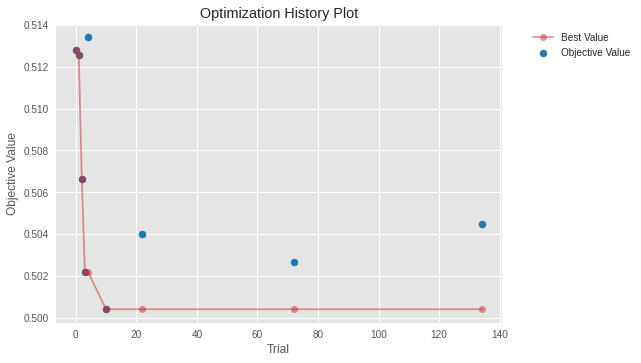

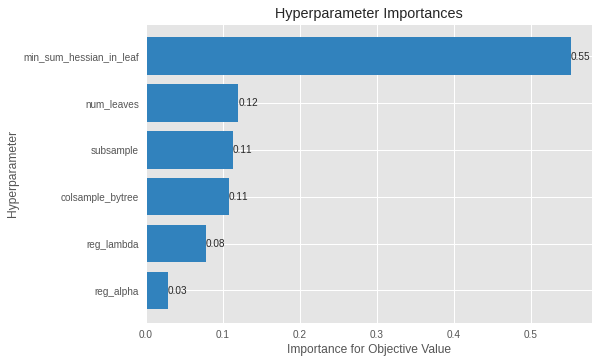

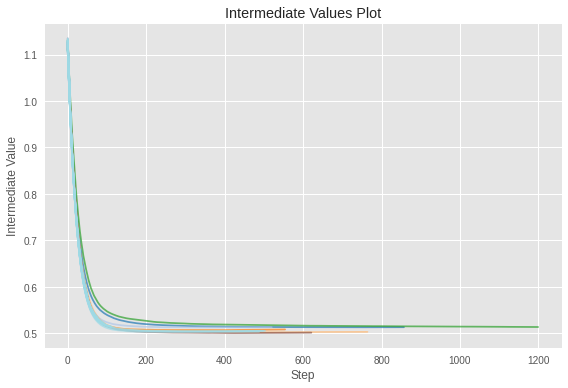

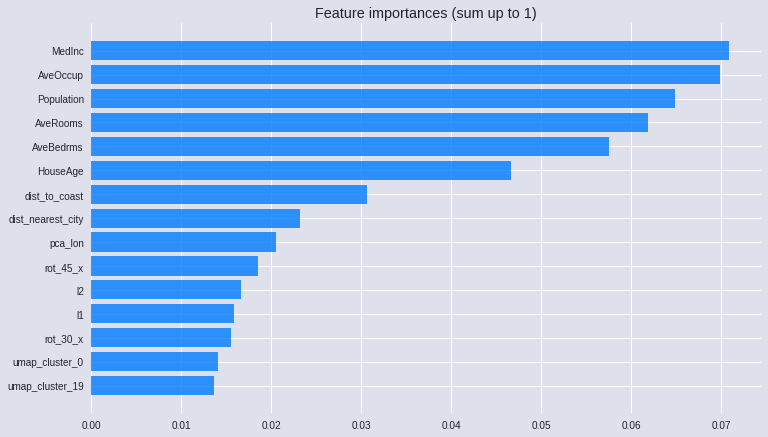


     . Optuna hyperparameters optimization finished
     .. Best trial number:10    |     rmse:           0.5004106520025978
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  455   |     rmse:            0.514358072740159

Time elapsed for fit execution: 12 min 45.367 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5117286335955025
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5112641915515377
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.4995790049050242
 ...........................

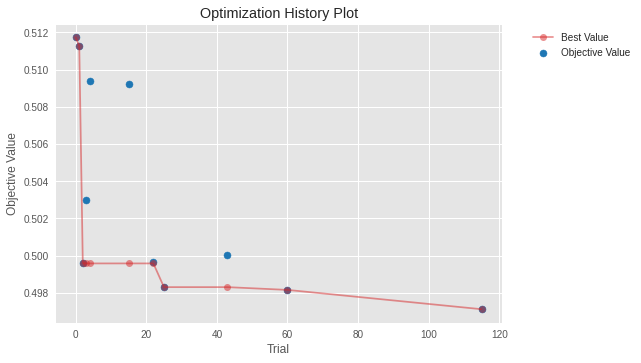

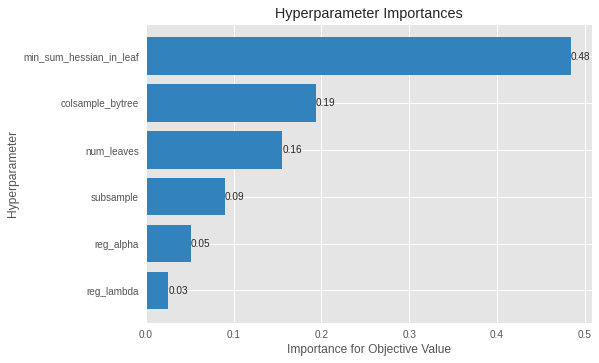

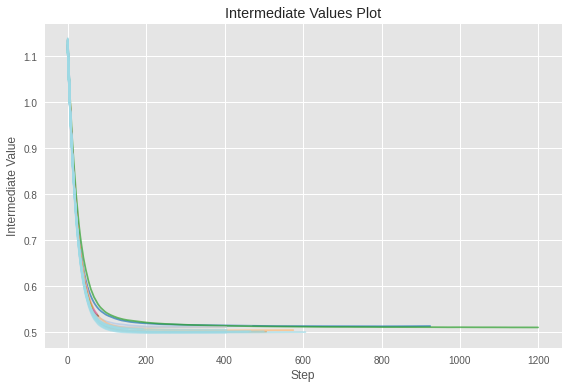

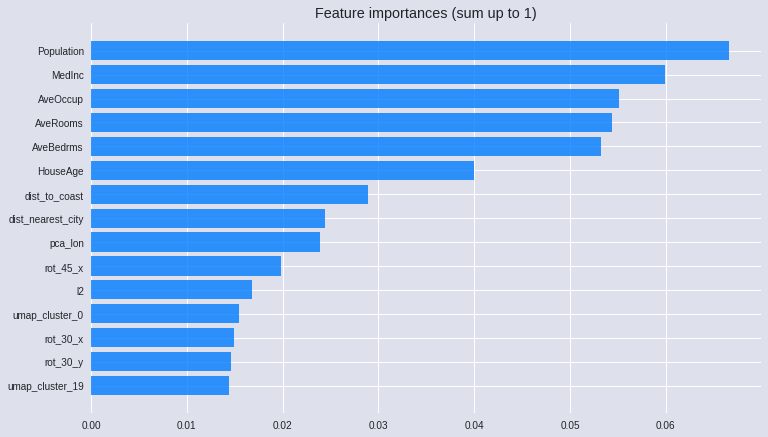


     . Optuna hyperparameters optimization finished
     .. Best trial number:115    |     rmse:          0.49711746185445205
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  319   |     rmse:           0.5147815769427404

Time elapsed for fit execution: 12 min 24.465 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5092427391683547
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5092452404221178
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5085114529083825
 ..........................

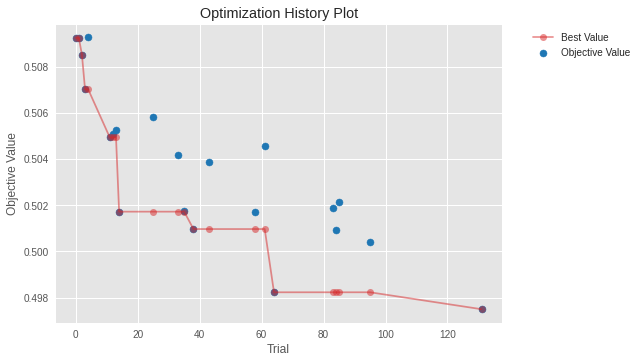

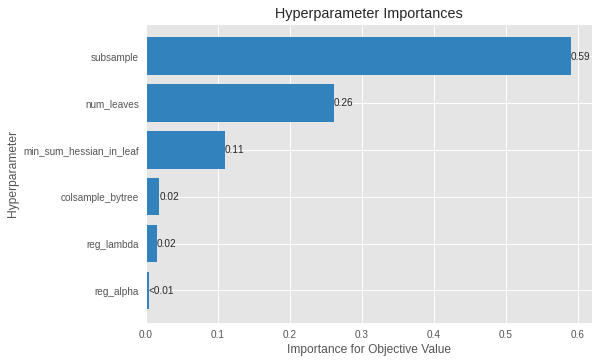

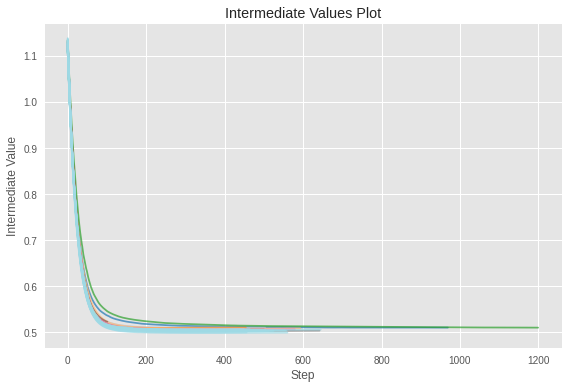

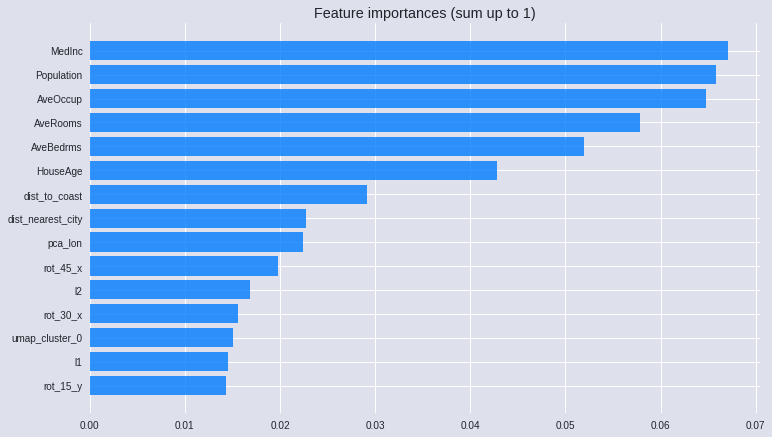


     . Optuna hyperparameters optimization finished
     .. Best trial number:131    |     rmse:          0.49749707144861743
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  314   |     rmse:           0.5145743509701898

Time elapsed for fit execution: 21 min 18.963 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5145968330408525
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5187548033426779
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.49829150064746525
 .........................

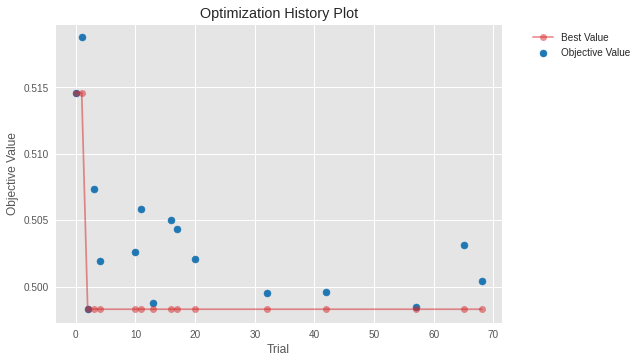

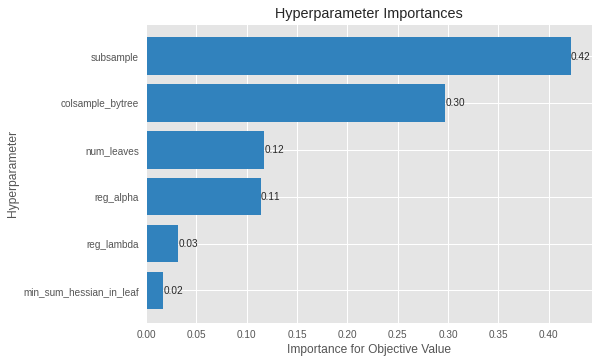

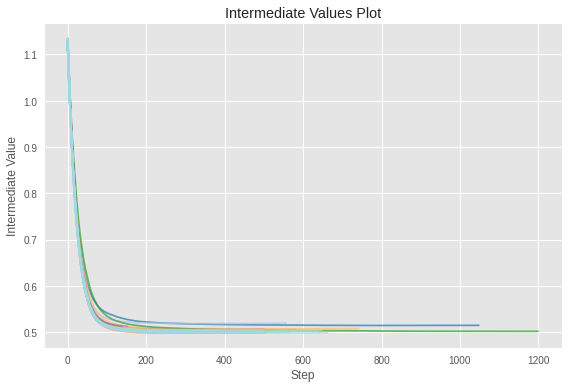

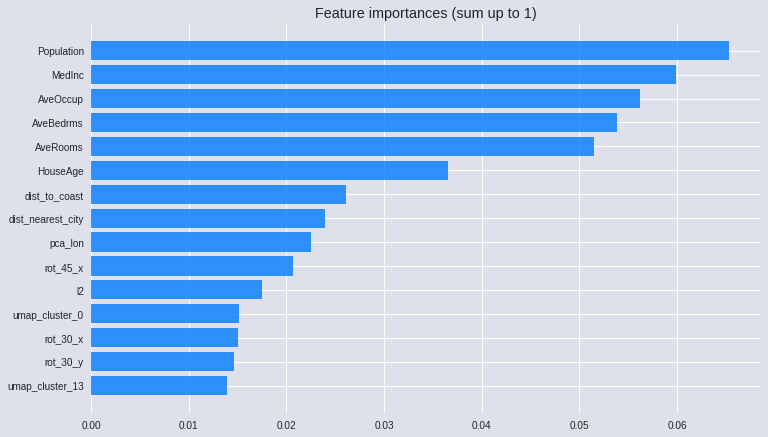


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     rmse:          0.49829150064746525
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  380   |     rmse:           0.5143007101400684

Time elapsed for fit execution: 16 min 16.562 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5088025833587777
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5114570021285221
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5075666470569052
 ...........................

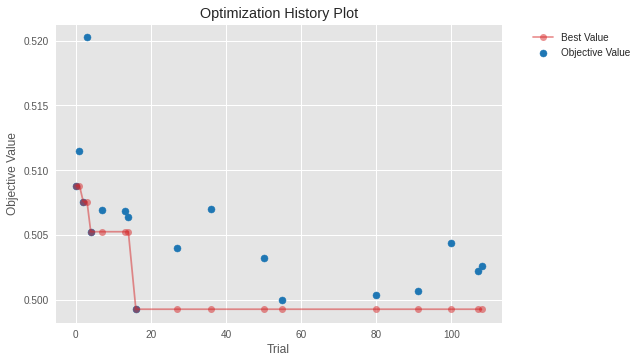

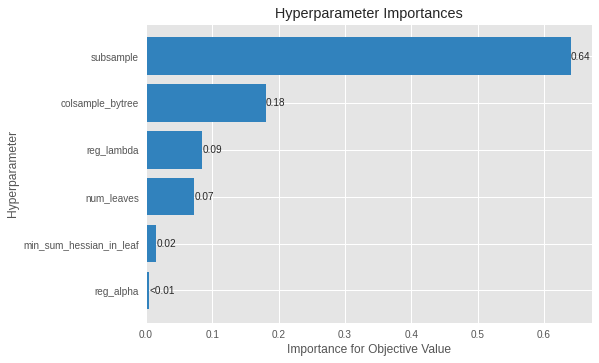

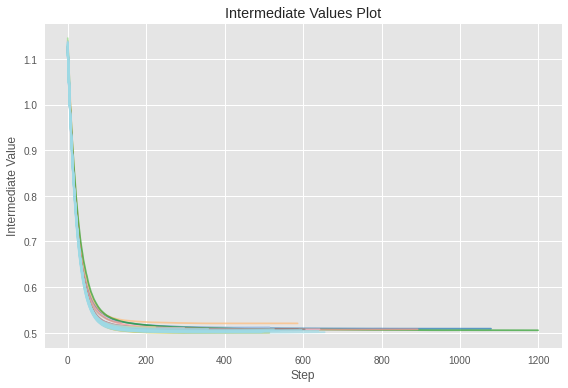

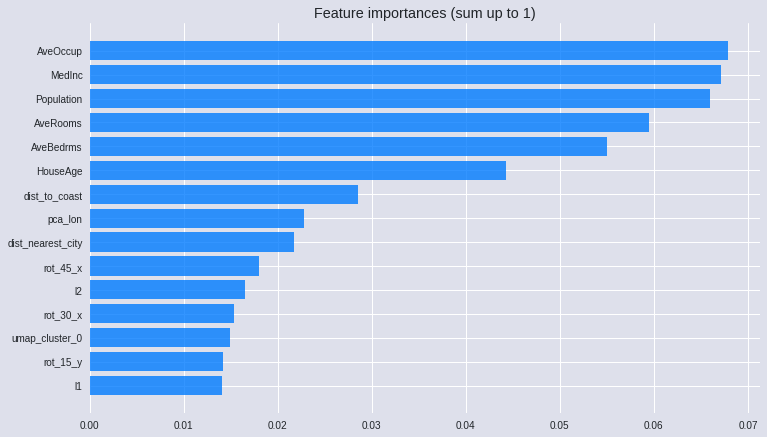


     . Optuna hyperparameters optimization finished
     .. Best trial number:16    |     rmse:          0.49926550081390175
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  390   |     rmse:           0.5135557686583393

Time elapsed for fit execution: 18 min 12.834 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5030292599469735
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5119844830700948
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.49459771977427097
 ..........................

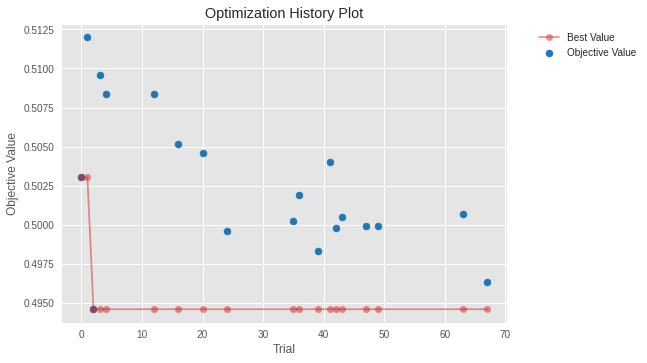

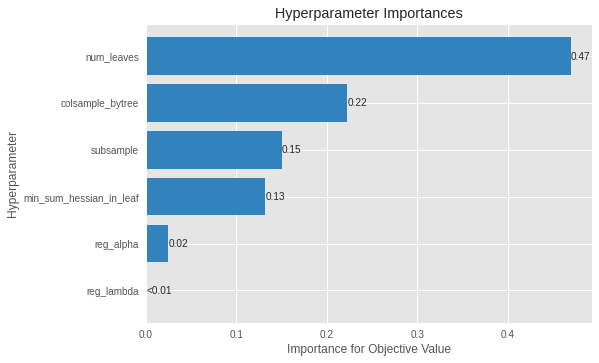

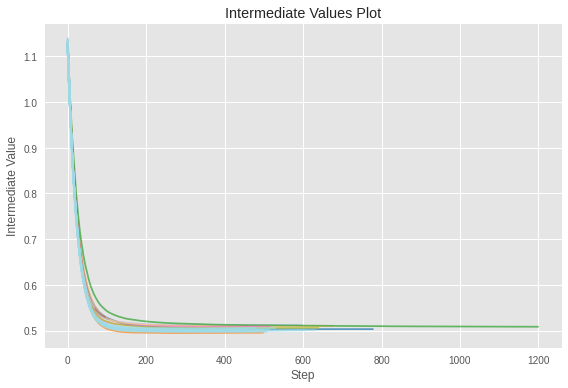

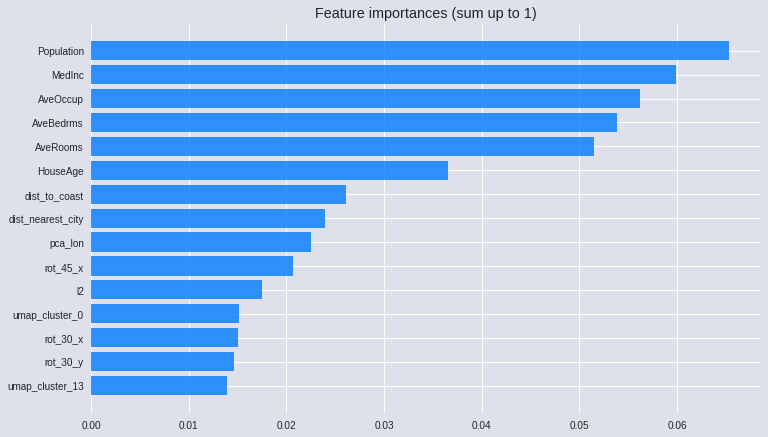


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     rmse:          0.49459771977427097
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  380   |     rmse:           0.5143007101400684

Time elapsed for fit execution: 18 min 43.436 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5118636995568436
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5143054248731165
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5024062048439032
 ...........................

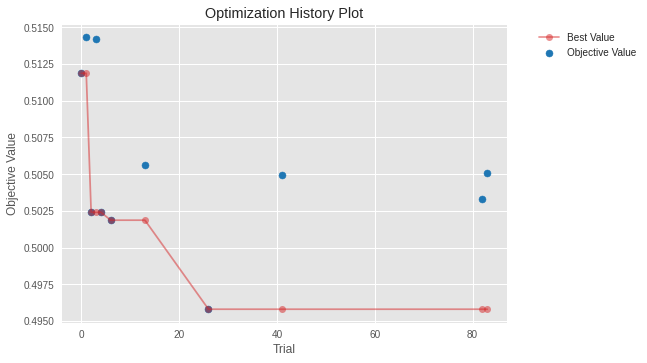

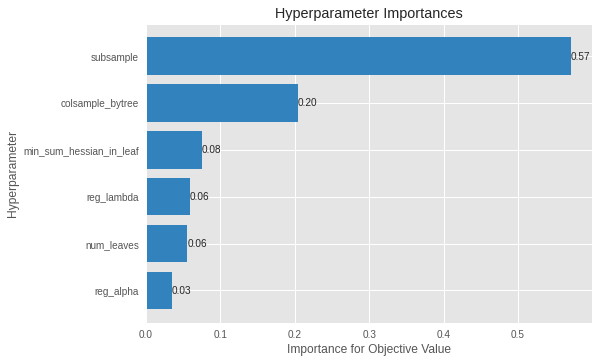

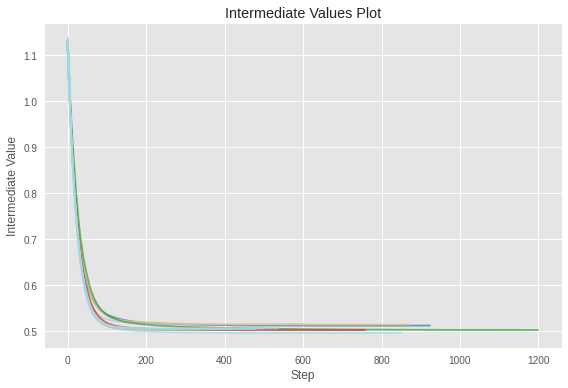

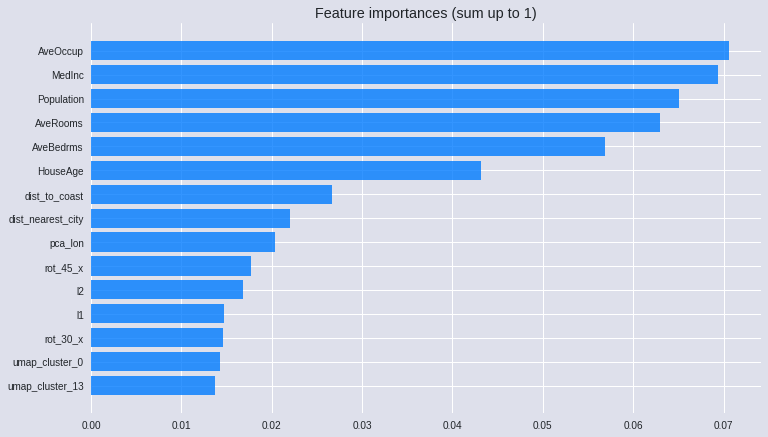


     . Optuna hyperparameters optimization finished
     .. Best trial number:26    |     rmse:           0.4958071986710368
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  654   |     rmse:           0.5136231891691275

Time elapsed for fit execution: 10 min 14.953 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.509474757787831
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5035066040449828
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5074257001236879
 ............................

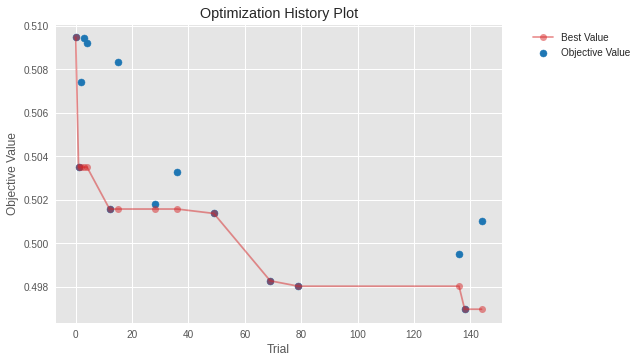

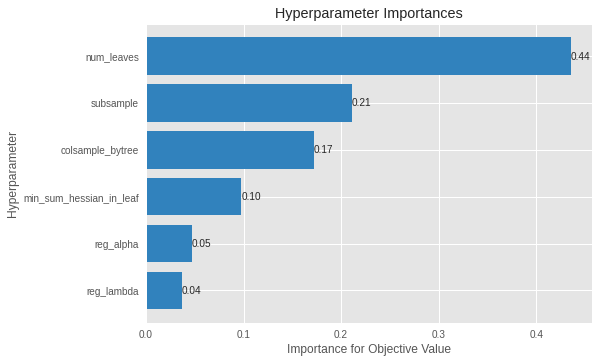

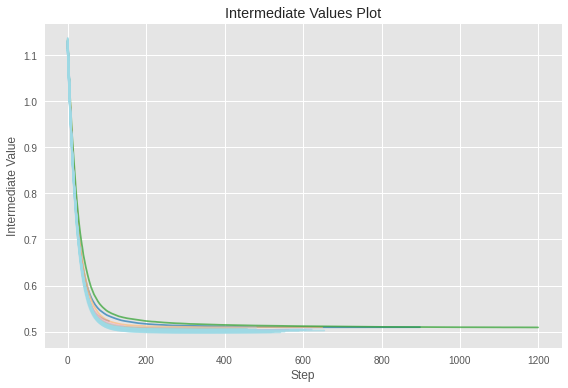

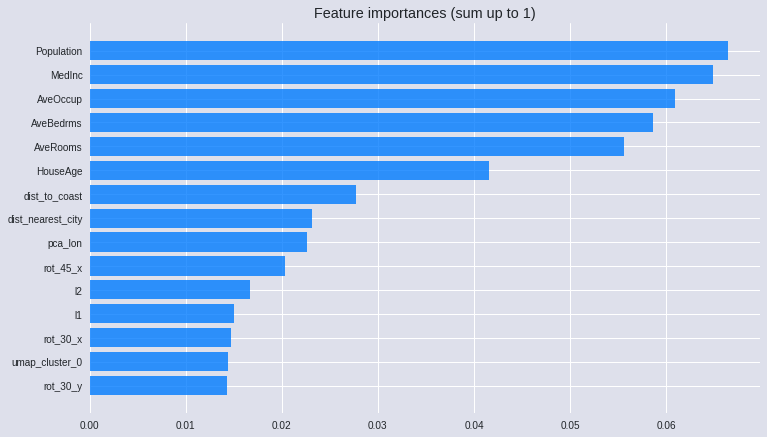


     . Optuna hyperparameters optimization finished
     .. Best trial number:138    |     rmse:          0.49696661910988227
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  404   |     rmse:           0.5146031807627688

Time elapsed for fit execution: 14 min 37.778 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.503633385609046
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5097888347762674
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5028093828602886
 ...........................

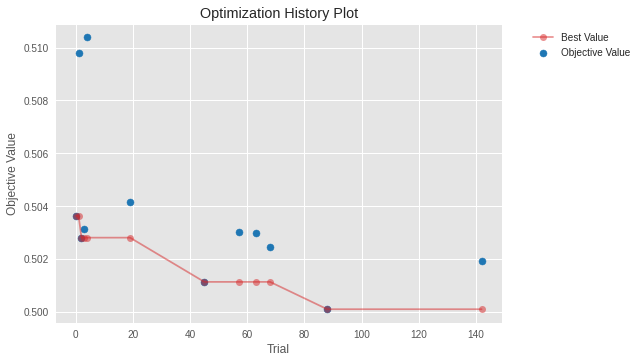

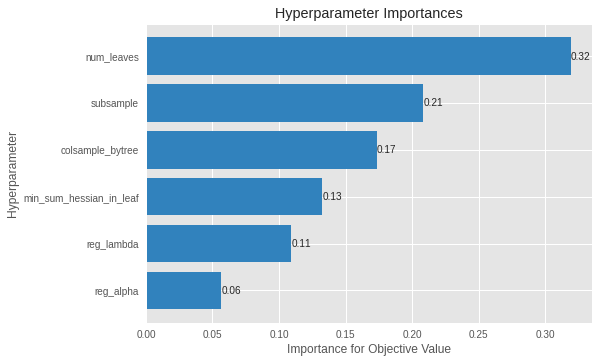

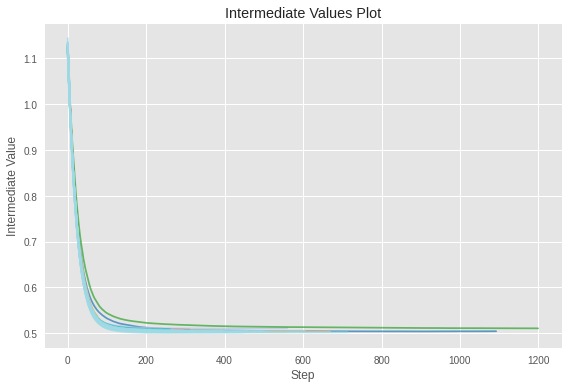

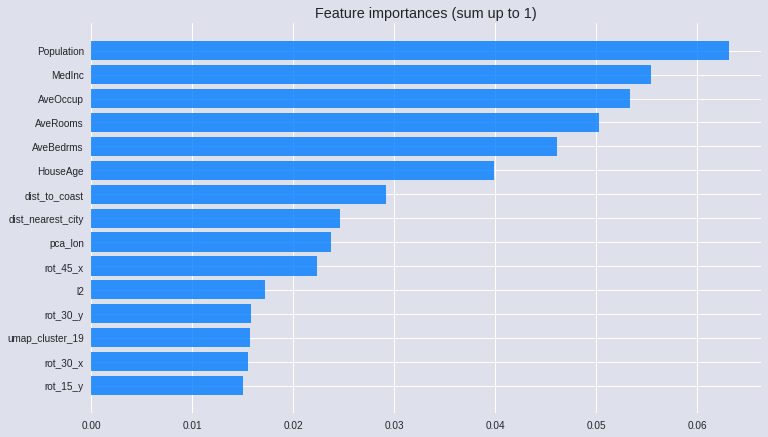


     . Optuna hyperparameters optimization finished
     .. Best trial number:88    |     rmse:           0.5001016748143403
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  257   |     rmse:           0.5142630184734328

Time elapsed for fit execution: 16 min 26.939 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5042165844300212
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5182973570301959
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5054710780898953
 ...........................

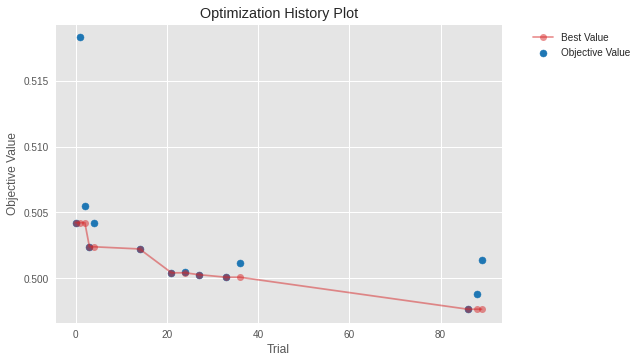

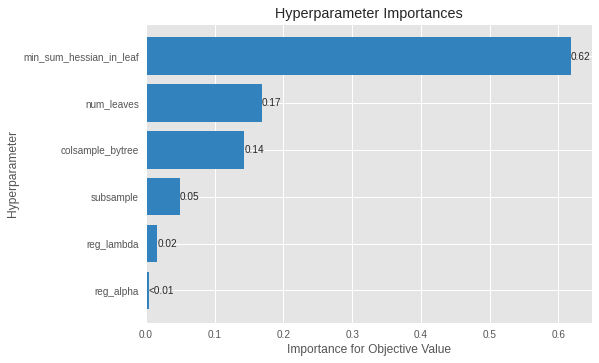

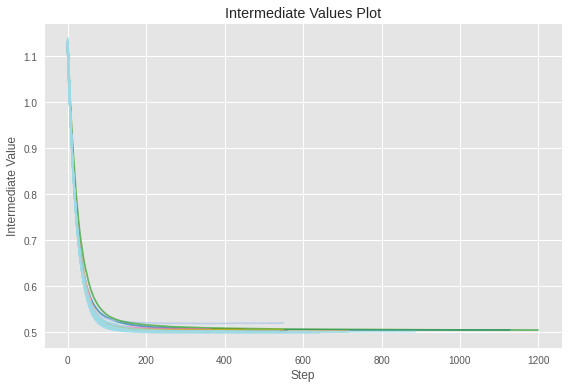

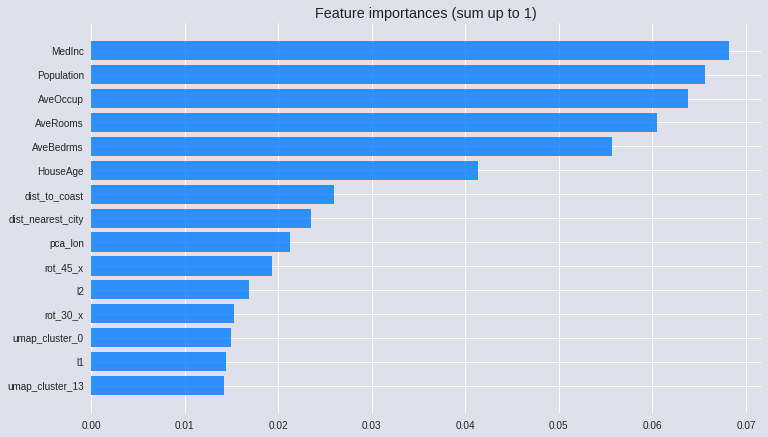


     . Optuna hyperparameters optimization finished
     .. Best trial number:86    |     rmse:          0.49764172047031924
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  456   |     rmse:           0.5134639097755767

Time elapsed for fit execution: 14 min 51.512 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5103368801466559
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5146160054114224
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5129907265601898
 ...........................

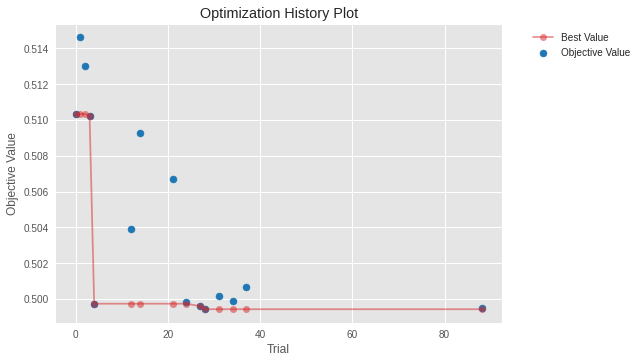

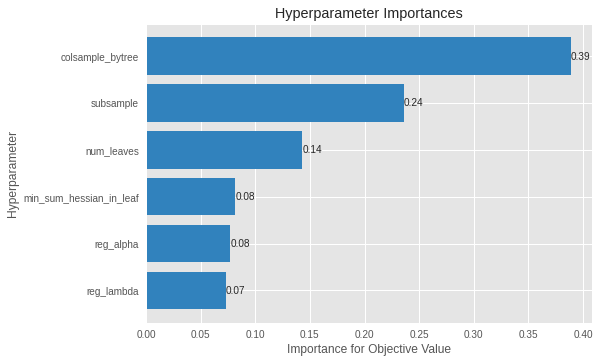

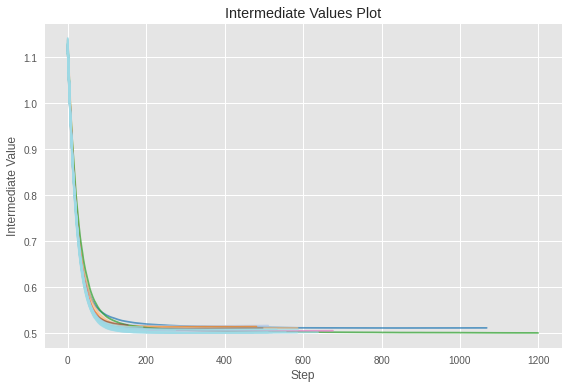

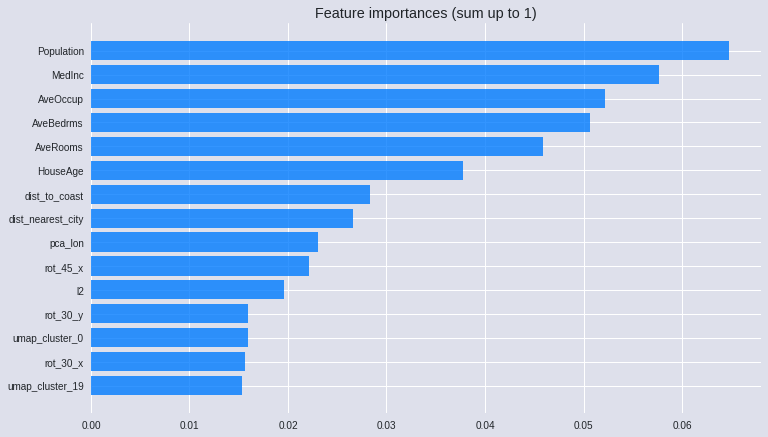


     . Optuna hyperparameters optimization finished
     .. Best trial number:28    |     rmse:           0.4994256153352355
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  372   |     rmse:           0.5132097382948588

Time elapsed for fit execution: 14 min 14.428 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5047069448387799
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5195365260399135
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5110040833443673
 ...........................

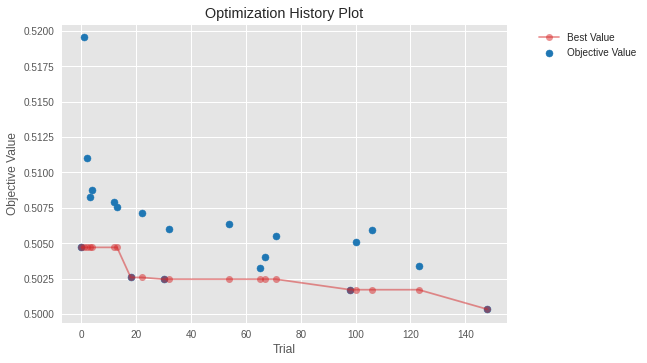

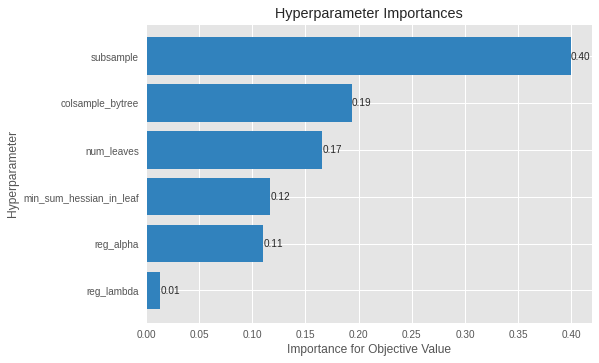

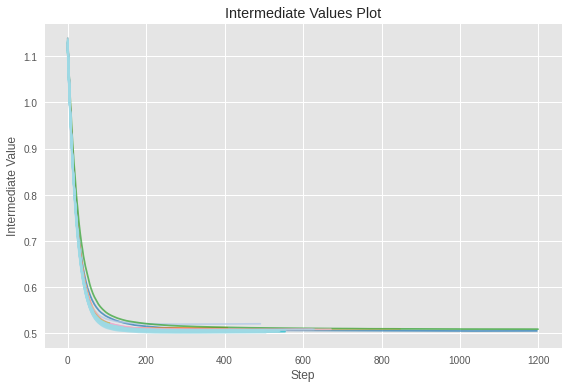

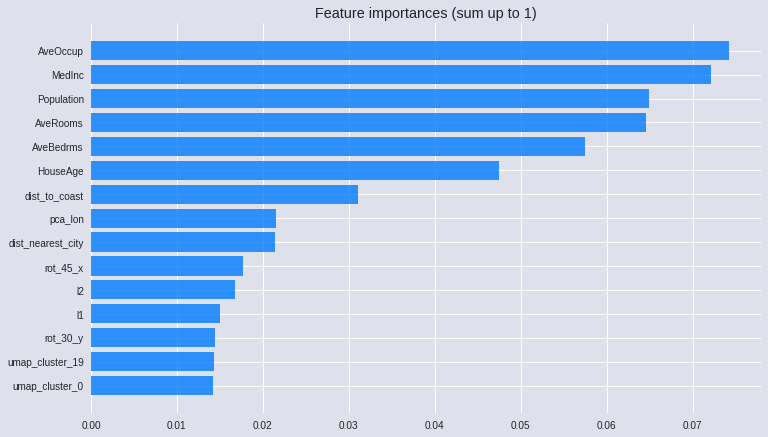


     . Optuna hyperparameters optimization finished
     .. Best trial number:148    |     rmse:           0.5003397808485167
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  345   |     rmse:           0.5156004494999421

Time elapsed for fit execution: 20 min 10.851 sec
None


In [ ]:
Mean_Prediction, predictions, a = stable_prediction(12, scaled_X, scaled_test)

In [ ]:
pd.DataFrame( Mean_Prediction ).to_csv('non_pca.csv')

### umap_cluster 제거

In [ ]:
drop_cols = [f'umap_cluster_{i}'for i in range(20)]
scaled_X = scaled_X.drop( drop_cols , axis=1 )
scaled_test = scaled_test.drop( drop_cols , axis=1 )
len(scaled_X.columns), len(scaled_test.columns)

(66, 65)


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5116153423488375
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.505425398909535
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5067277383683755
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 0.505187018543232
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 0.5072461183298831
 ................................................

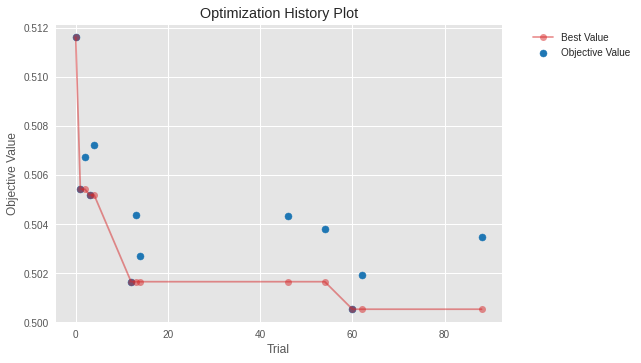

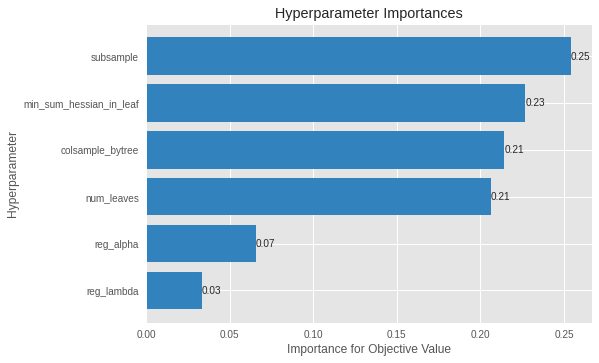

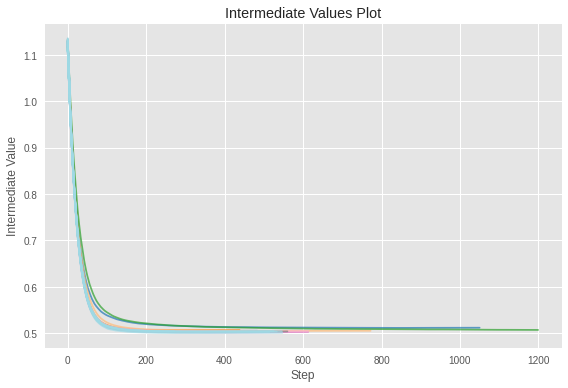

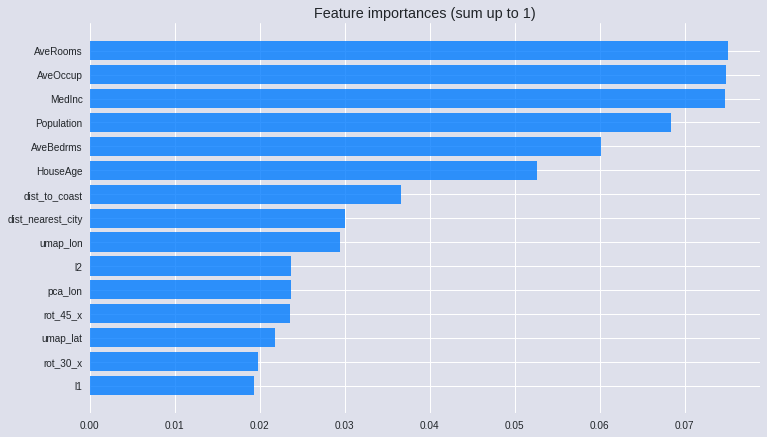


     . Optuna hyperparameters optimization finished
     .. Best trial number:60    |     rmse:           0.5005322045677657
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  344   |     rmse:           0.5153662222123029

Time elapsed for fit execution: 12 min 14.222 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.504589545457322
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5054179705568926
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5045741291128082
 ............................

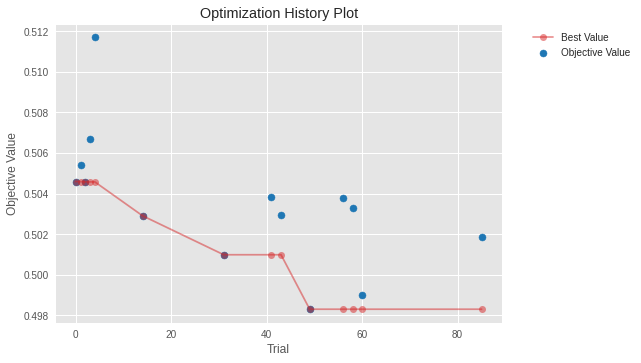

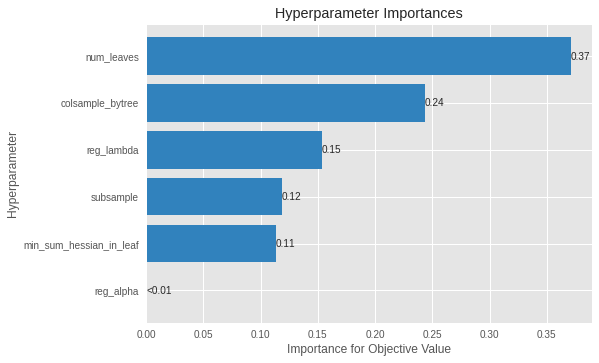

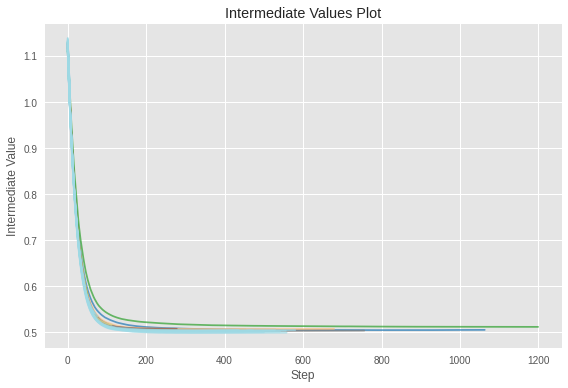

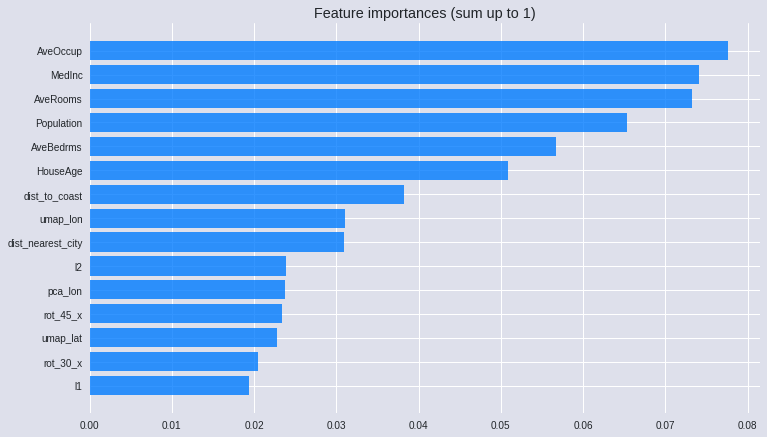


     . Optuna hyperparameters optimization finished
     .. Best trial number:49    |     rmse:           0.4982990184971203
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  319   |     rmse:           0.5157100355594062

Time elapsed for fit execution: 13 min 9.912 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5041345679532631
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5027921013461022
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5039601663843306
 ............................

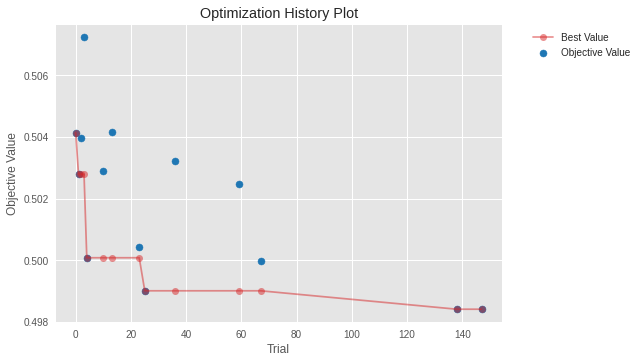

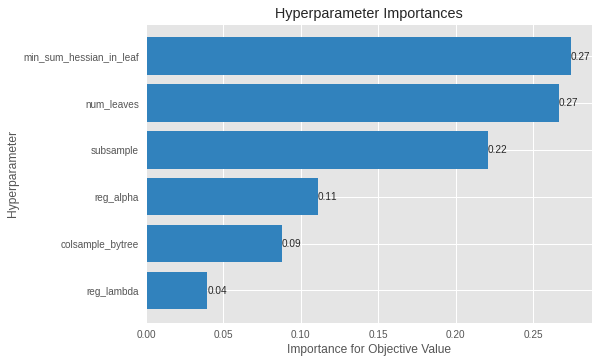

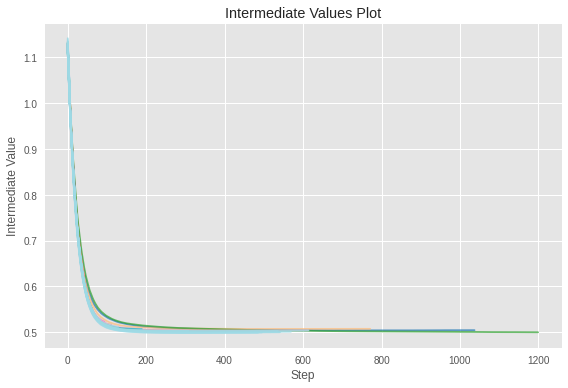

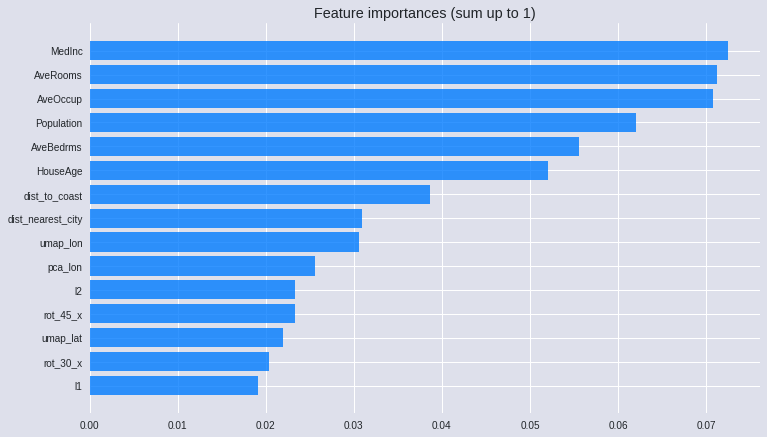


     . Optuna hyperparameters optimization finished
     .. Best trial number:138    |     rmse:           0.4984113966317807
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  313   |     rmse:           0.5149642896715635

Time elapsed for fit execution: 13 min 37.787 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5015437361383532
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5007401242593297
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5016397267056583
 ..........................

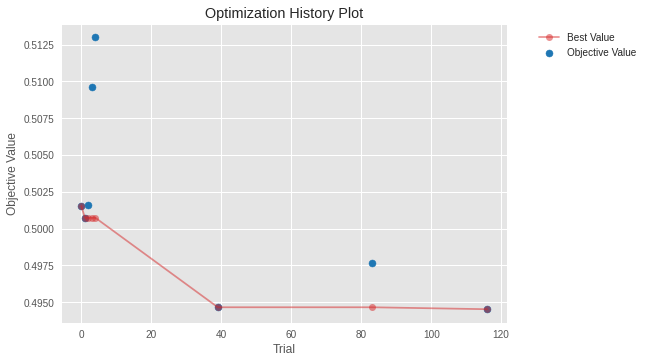

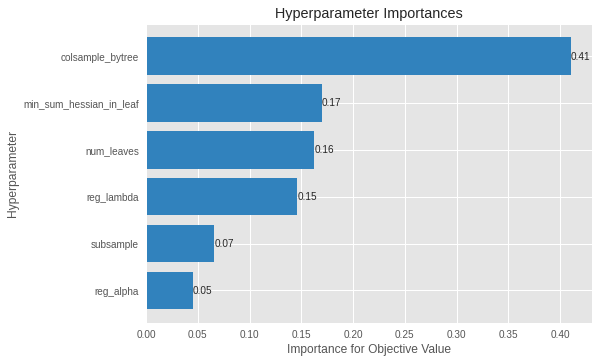

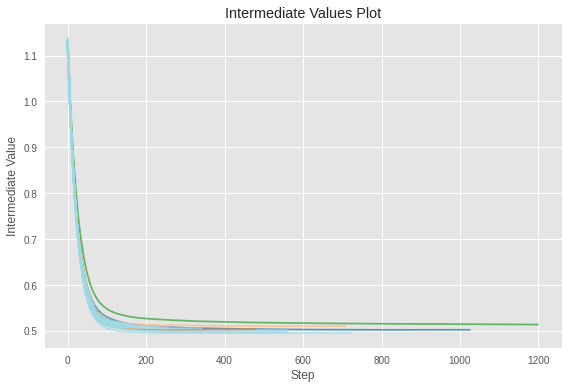

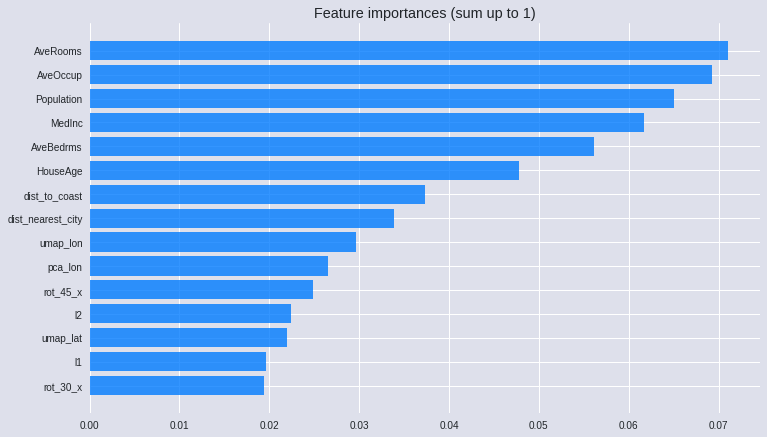


     . Optuna hyperparameters optimization finished
     .. Best trial number:116    |     rmse:          0.49452816670123245
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  360   |     rmse:           0.5143381745032949

Time elapsed for fit execution: 14 min 20.26 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5068439532655235
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5017951890794248
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5067424369895477
 ...........................

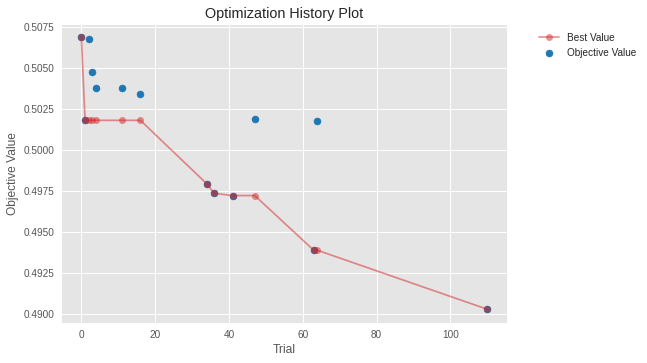

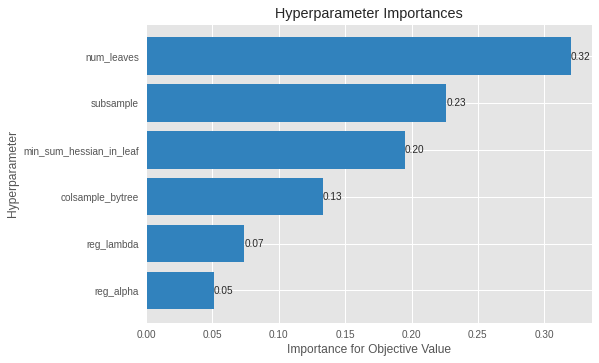

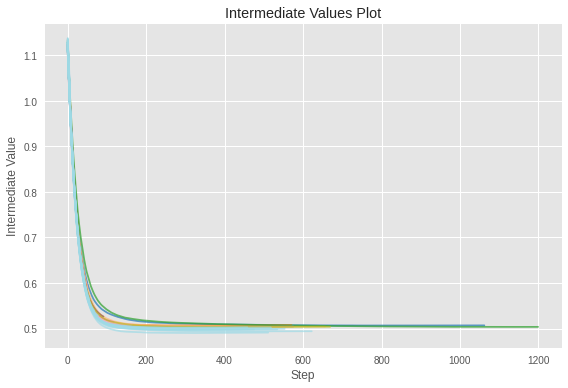

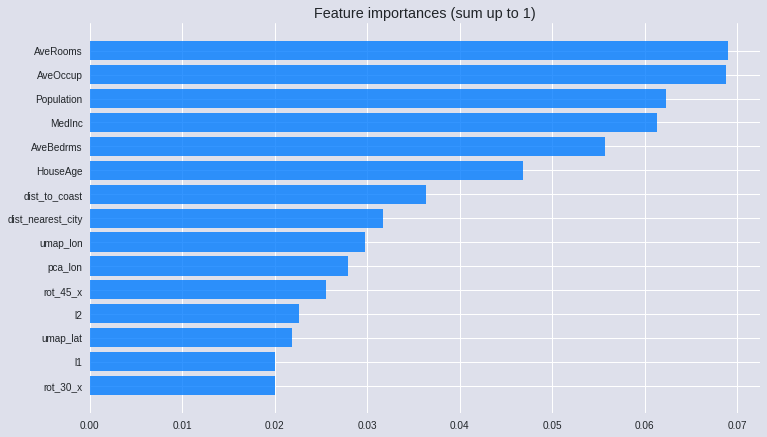


     . Optuna hyperparameters optimization finished
     .. Best trial number:110    |     rmse:          0.49029649298596156
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  352   |     rmse:           0.5133519922220724

Time elapsed for fit execution: 12 min 50.402 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5066646385662397
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.506475908869186
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5035654605169985
 ...........................

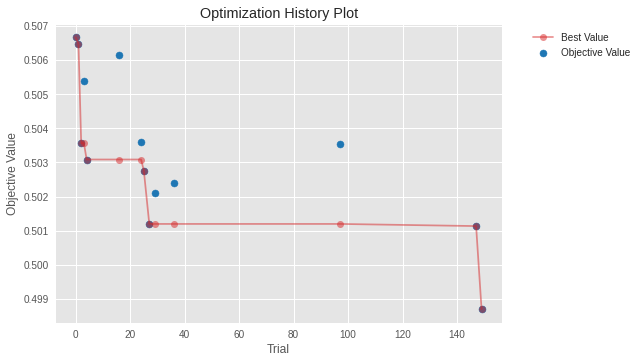

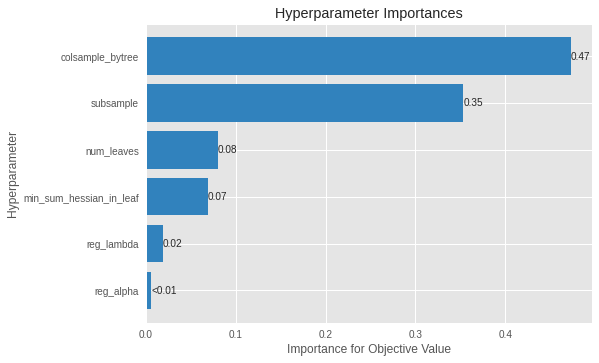

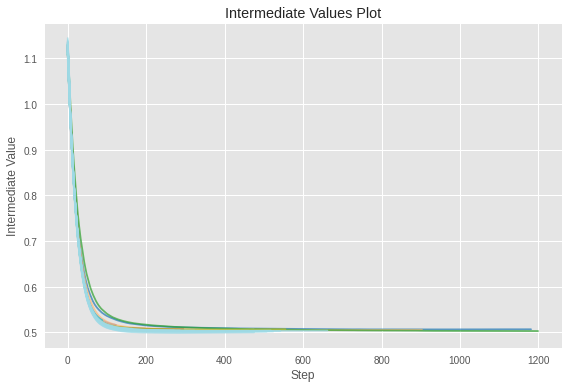

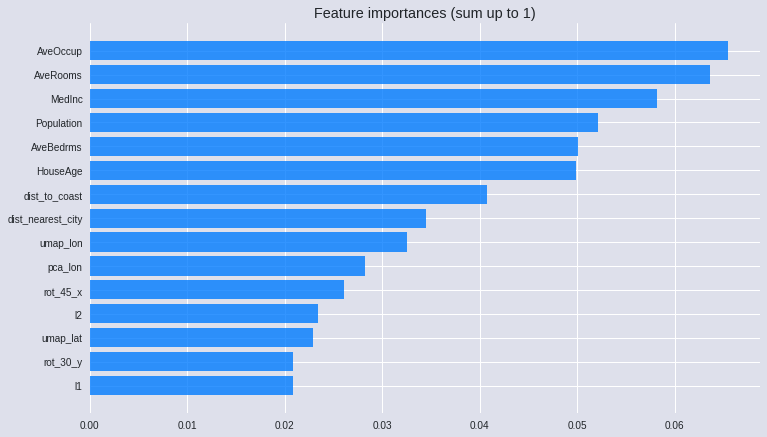


     . Optuna hyperparameters optimization finished
     .. Best trial number:149    |     rmse:           0.4986984428411123
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  230   |     rmse:           0.5151229078396448

Time elapsed for fit execution: 13 min 36.076 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5088633868365952
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5079672150741776
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5033868184706265
 ..........................

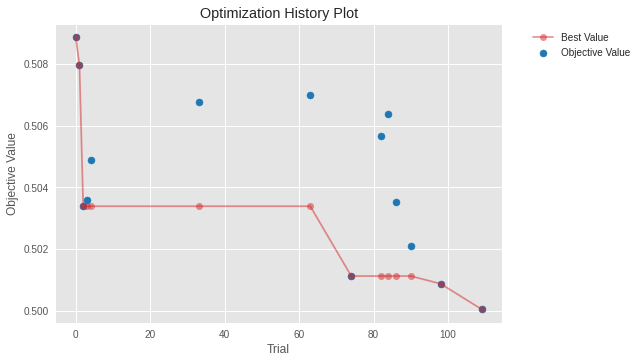

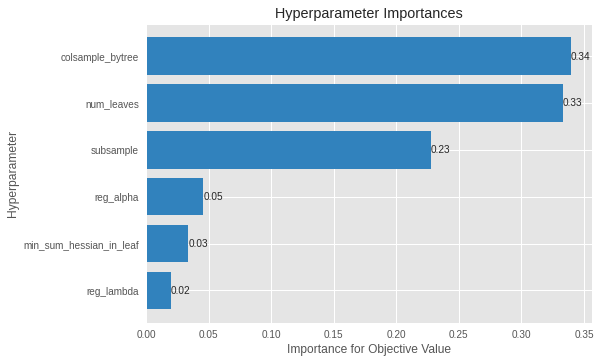

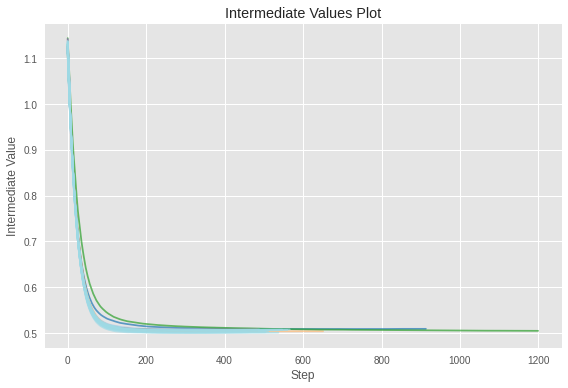

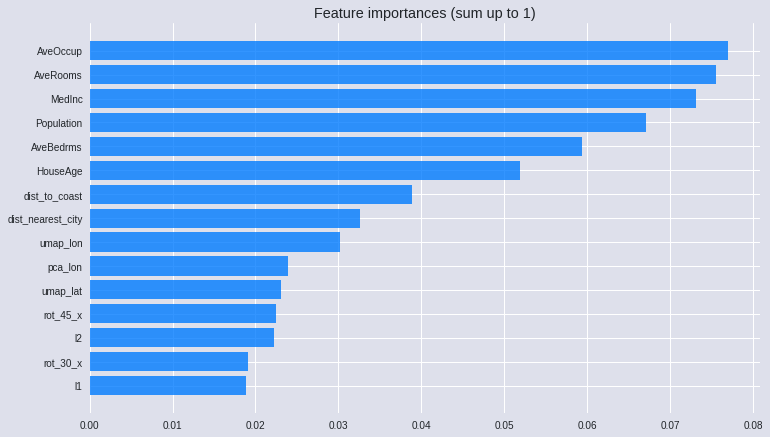


     . Optuna hyperparameters optimization finished
     .. Best trial number:109    |     rmse:           0.5000473302543261
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  337   |     rmse:           0.5160422599658205

Time elapsed for fit execution: 14 min 4.666 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5100341580638522
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5132460061015026
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.49624844091473225
 ..........................

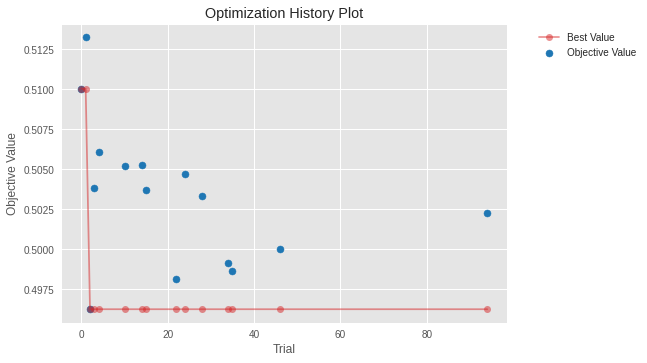

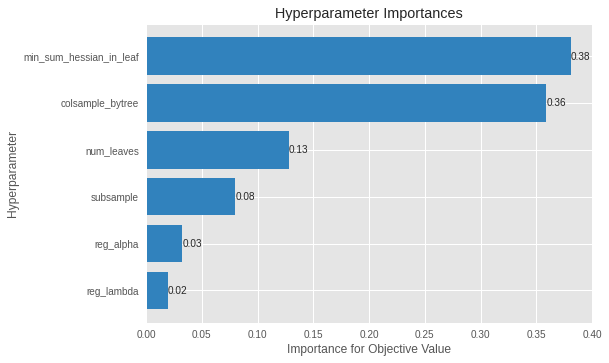

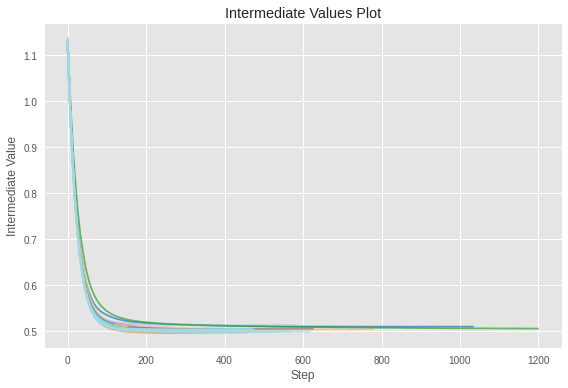

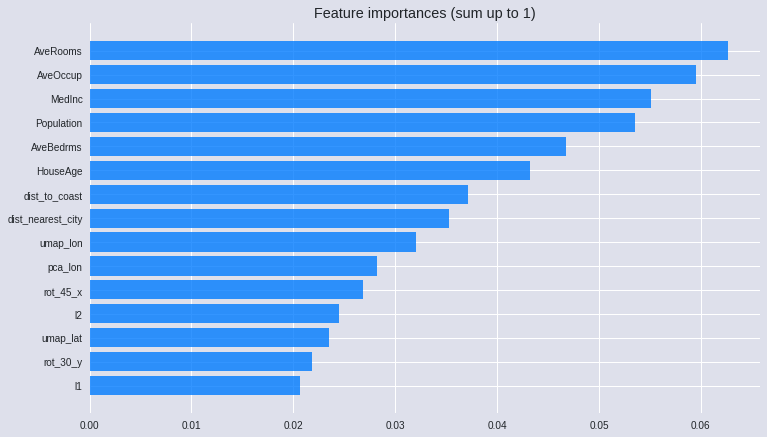


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     rmse:          0.49624844091473225
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  274   |     rmse:           0.5128114072933976

Time elapsed for fit execution: 12 min 52.905 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5112235418323208
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5092789367416467
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.4979850241174364
 ...........................

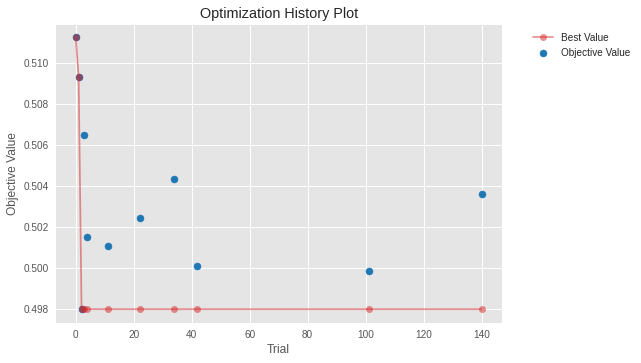

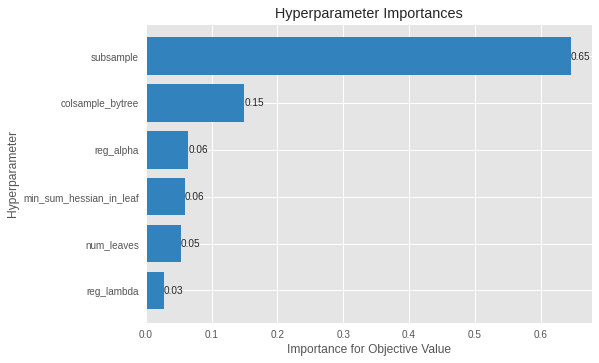

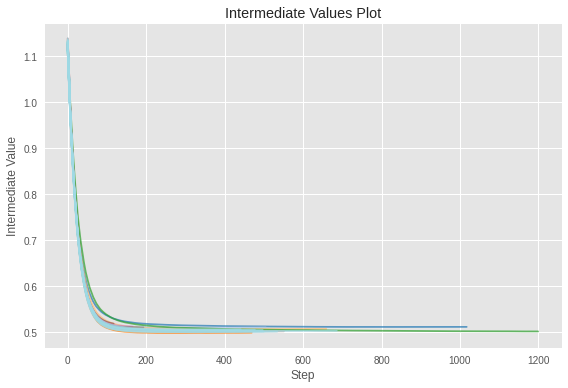

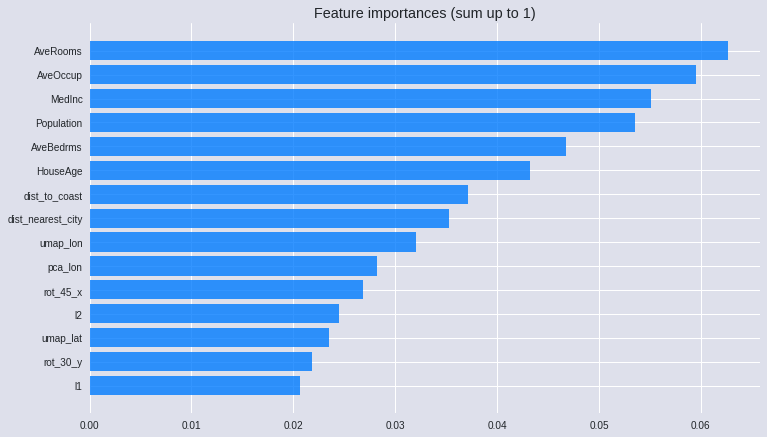


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     rmse:           0.4979850241174364
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  274   |     rmse:           0.5128114072933976

Time elapsed for fit execution: 10 min 32.883 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5037127251230984
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5139247955111439
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5009423658643488
 ...........................

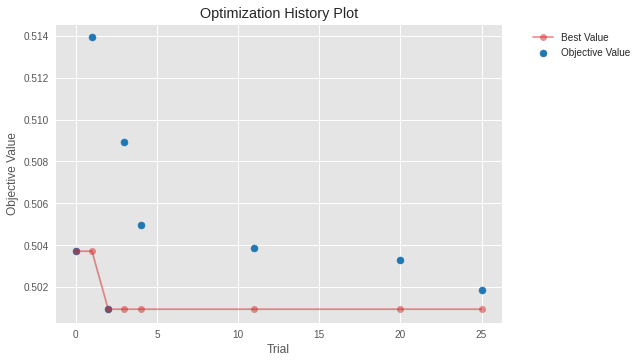

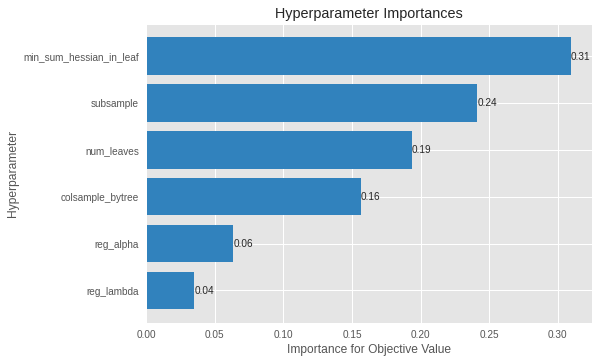

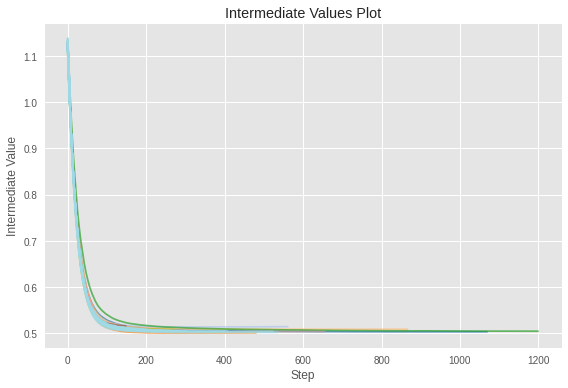

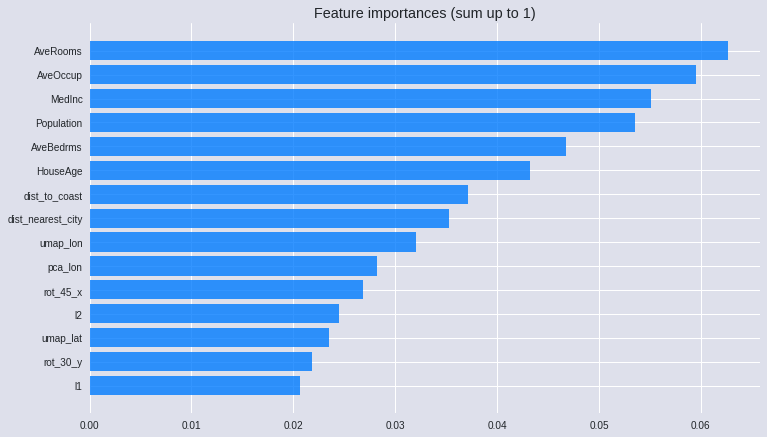


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     rmse:           0.5009423658643488
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  274   |     rmse:           0.5128114072933976

Time elapsed for fit execution: 15 min 7.48 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5055641399875213
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5098831790430888
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5049045108115787
 .............................

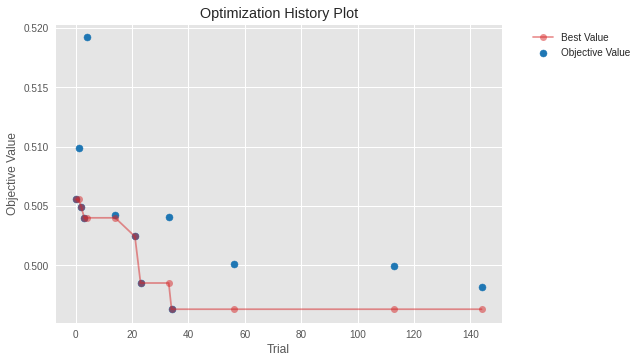

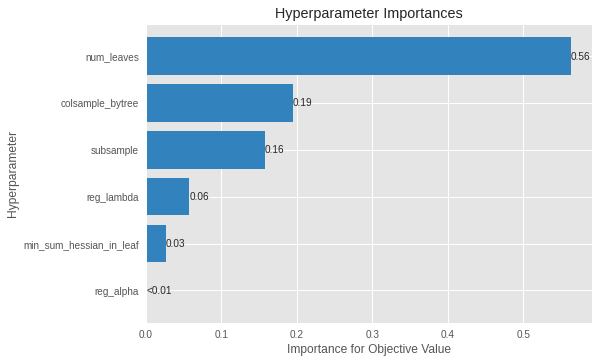

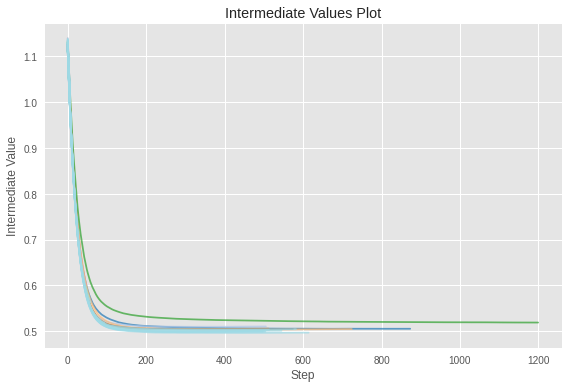

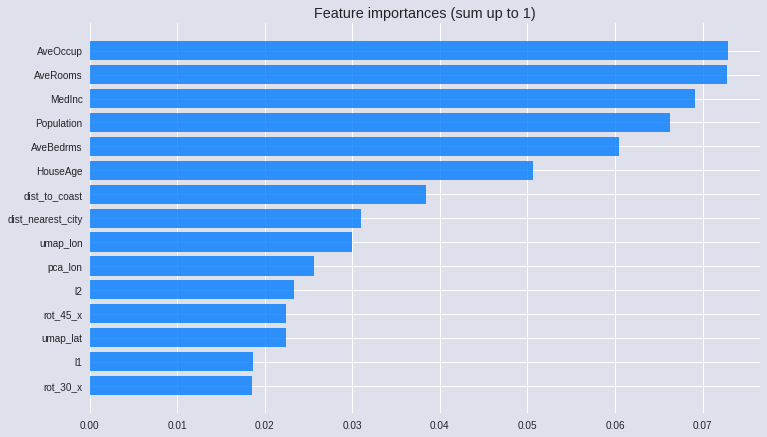


     . Optuna hyperparameters optimization finished
     .. Best trial number:34    |     rmse:           0.4963187563804127
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  377   |     rmse:            0.514597639561679

Time elapsed for fit execution: 12 min 48.015 sec
None

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5067184098286057
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5148479888321764
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.51245068572919
 .............................

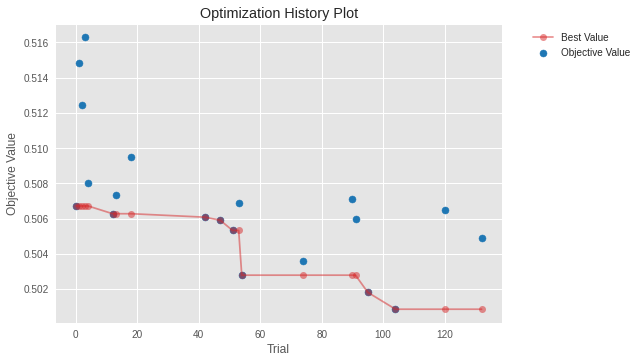

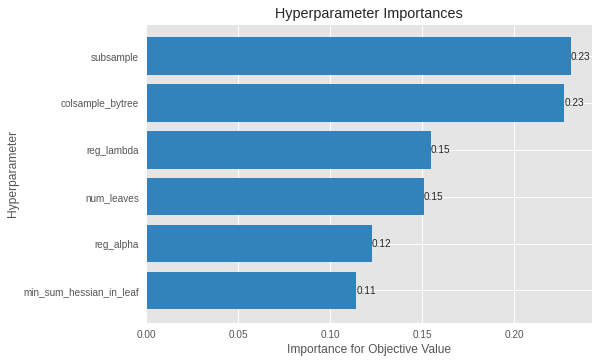

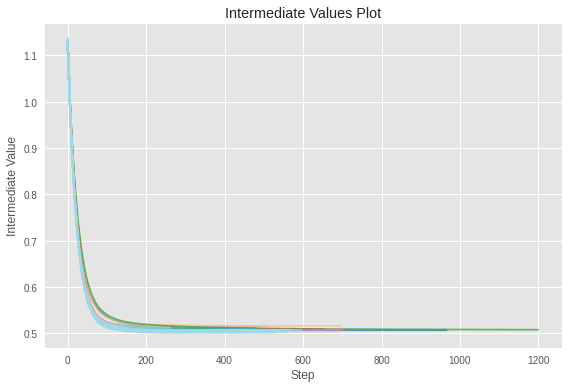

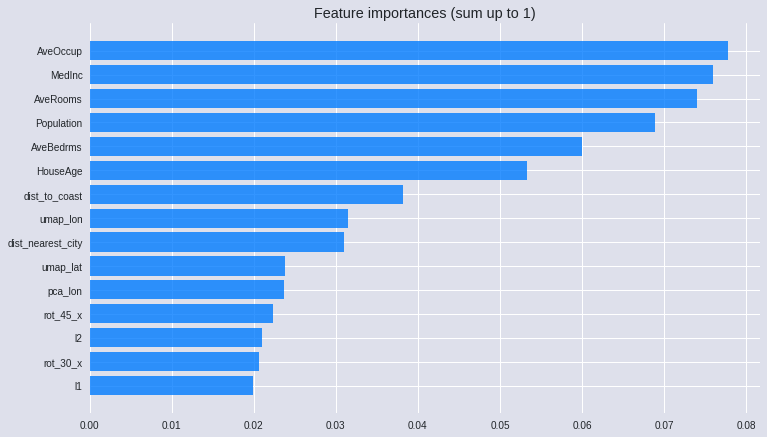


     . Optuna hyperparameters optimization finished
     .. Best trial number:104    |     rmse:            0.500855860382841
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  308   |     rmse:           0.5164381961385625

Time elapsed for fit execution: 19 min 9.698 sec
None


In [ ]:
Mean_Prediction, predictions, a = stable_prediction(12, scaled_X, scaled_test)

In [ ]:
pd.DataFrame( Mean_Prediction ).to_csv('non_umap.csv')

### cluster_3 제거

In [ ]:
drop_cols = [f'cluster_3_{i}'for i in range(3)]
scaled_X = scaled_X.drop( drop_cols , axis=1 )
scaled_test = scaled_test.drop( drop_cols , axis=1 )


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5002166667437025
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5031808054699677
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5045180004966797
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 0.5112245524726273
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 0.5068225440333626
 ..............................................

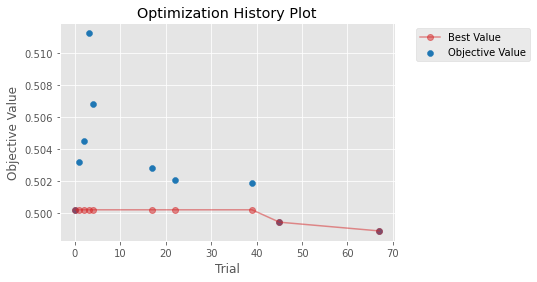

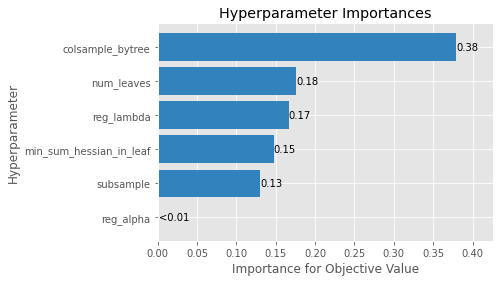

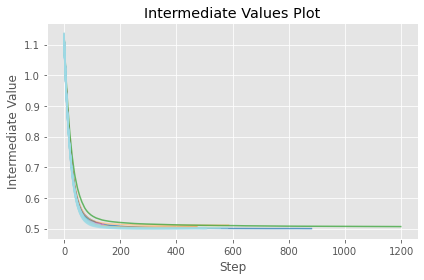

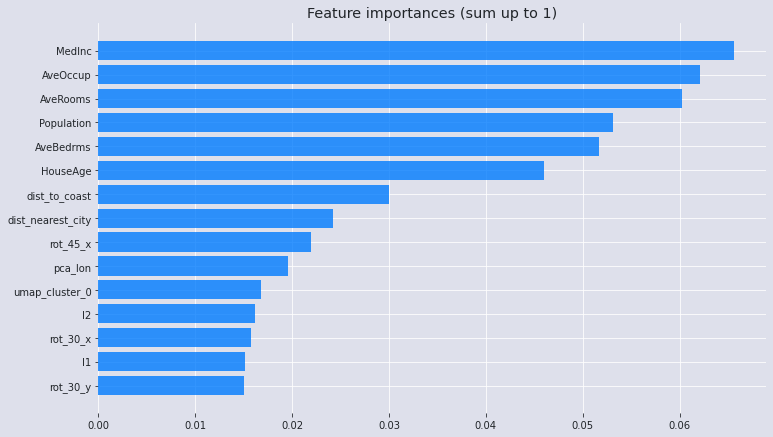


     . Optuna hyperparameters optimization finished
     .. Best trial number:67    |     rmse:           0.4988996437293178
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  250   |     rmse:           0.5159246738584768

Time elapsed for fit execution: 14 min 38.714 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.513062581521188
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5183111472140998
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5083923712060879
 .................................

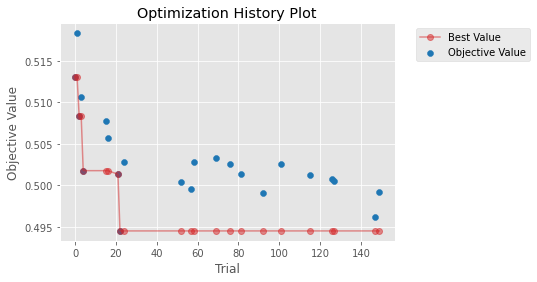

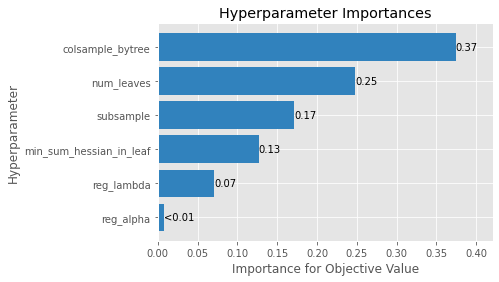

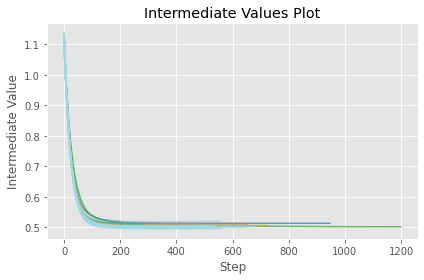

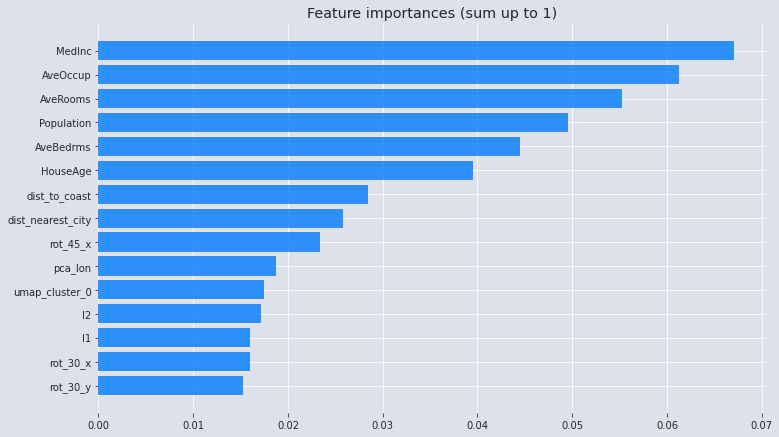


     . Optuna hyperparameters optimization finished
     .. Best trial number:22    |     rmse:          0.49450967283348385
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  321   |     rmse:           0.5131006815808861

Time elapsed for fit execution: 18 min 48.616 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5096745910653575
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5148619536656802
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.50338990479238
 ..................................

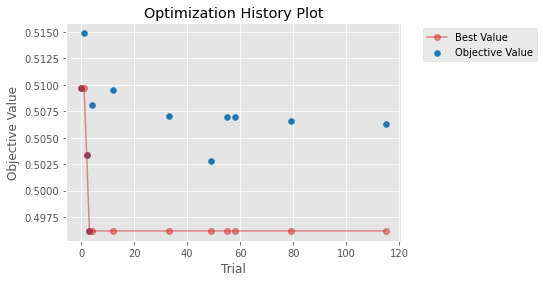

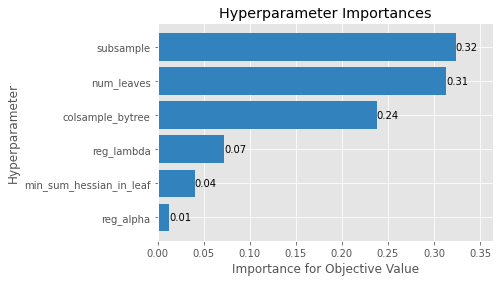

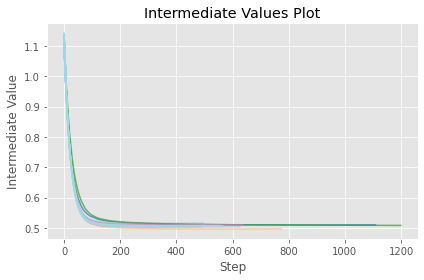

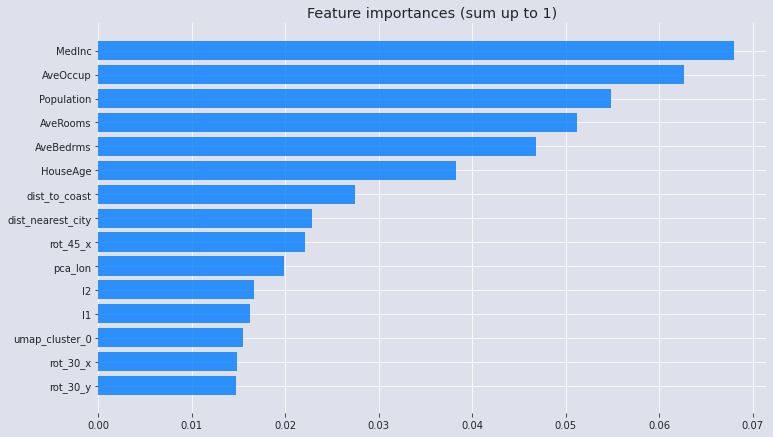


     . Optuna hyperparameters optimization finished
     .. Best trial number: 3    |     rmse:          0.49619903163709744
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  515   |     rmse:           0.5120161828407106

Time elapsed for fit execution: 14 min 3.999 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5012750982953831
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5092566160075347
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5133497883366069
 .................................

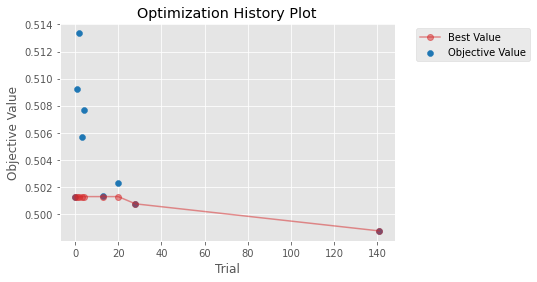

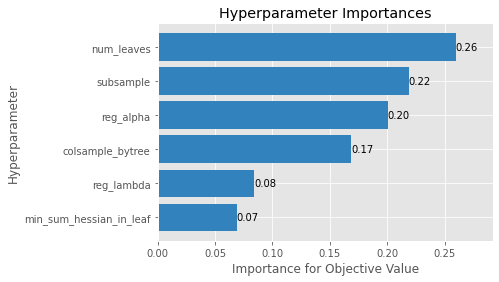

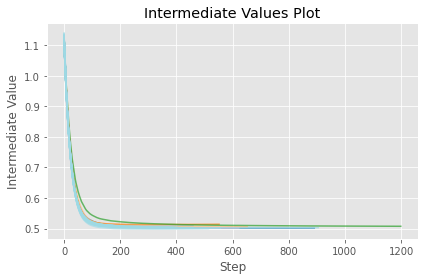

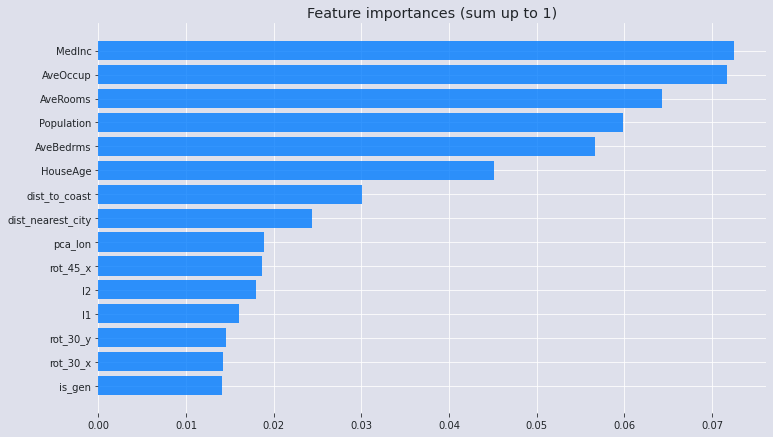


     . Optuna hyperparameters optimization finished
     .. Best trial number:141    |     rmse:          0.49873870592643754
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  353   |     rmse:           0.5159479514619847

Time elapsed for fit execution: 20 min 42.261 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.513659822943296
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5034053961245473
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5091725723752856
 ................................

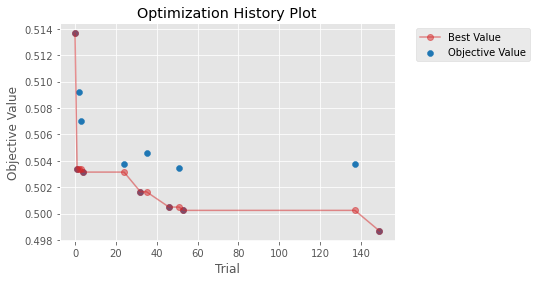

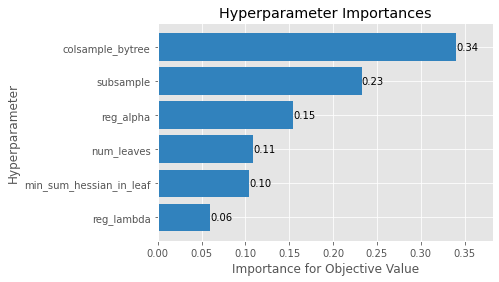

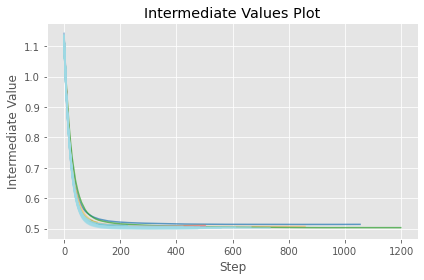

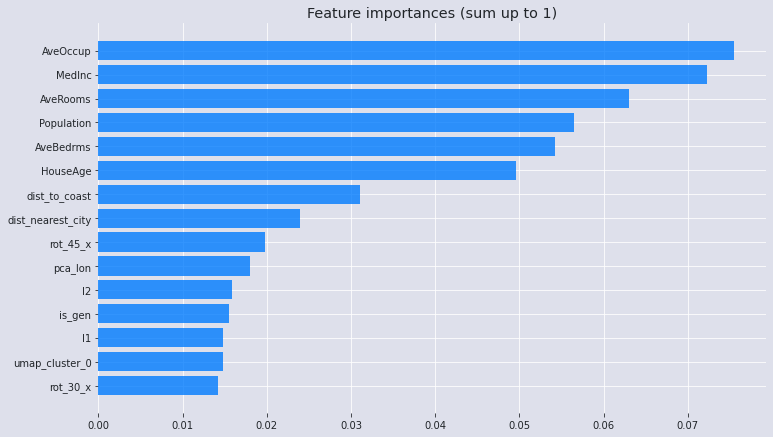


     . Optuna hyperparameters optimization finished
     .. Best trial number:149    |     rmse:           0.4986847064821773
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  277   |     rmse:           0.5167602442757248

Time elapsed for fit execution: 16 min 57.782 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5121820287388879
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5059138438075003
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5028960558802457
 ...............................

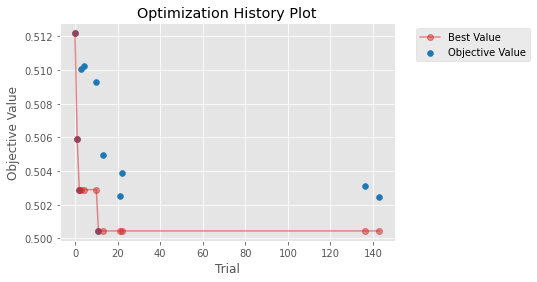

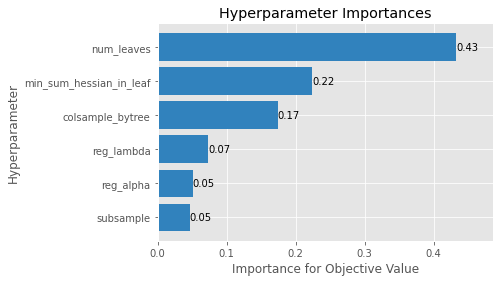

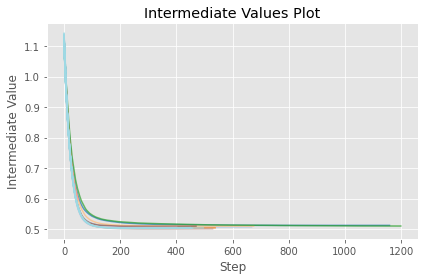

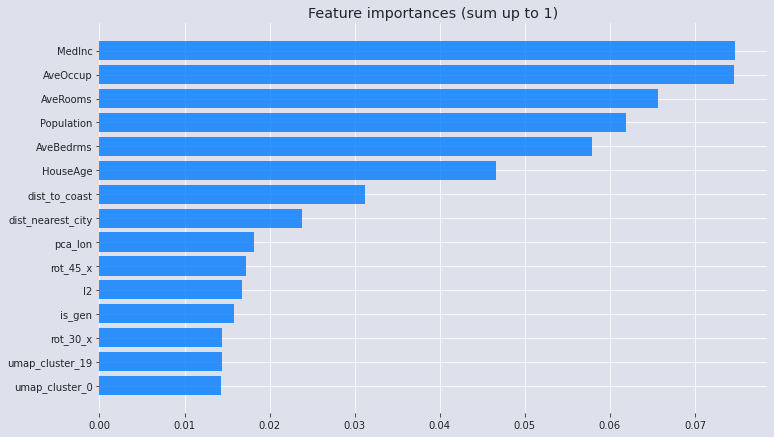


     . Optuna hyperparameters optimization finished
     .. Best trial number:11    |     rmse:           0.5004437809951154
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  343   |     rmse:           0.5162846562207359

Time elapsed for fit execution: 14 min 50.991 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5083494504359277
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5146321277795517
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5126004131856734
 ................................

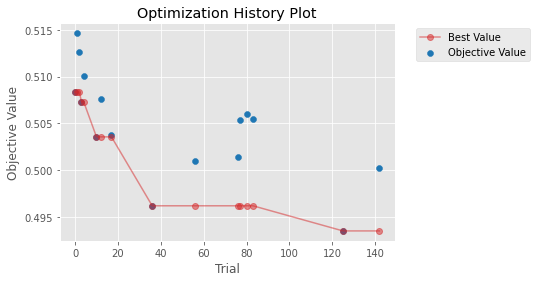

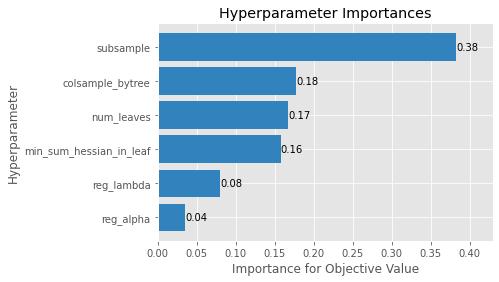

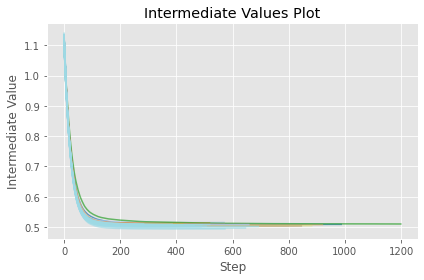

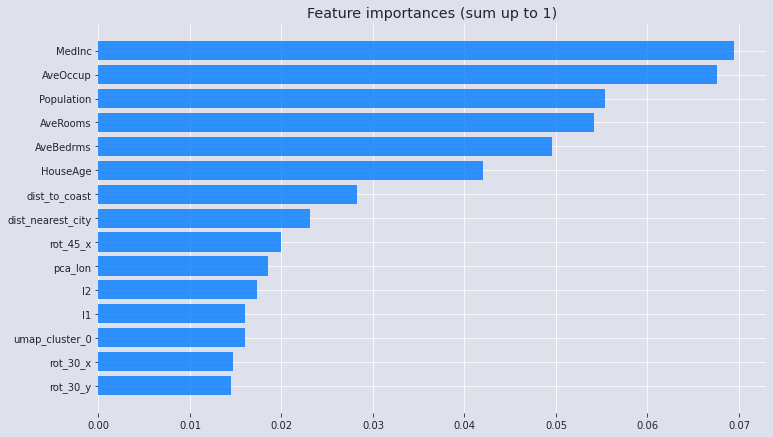


     . Optuna hyperparameters optimization finished
     .. Best trial number:125    |     rmse:           0.4935209396493934
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  526   |     rmse:            0.513396465764702

Time elapsed for fit execution: 19 min 26.577 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5071393404868574
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5180595758556734
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5073514251146626
 ...............................

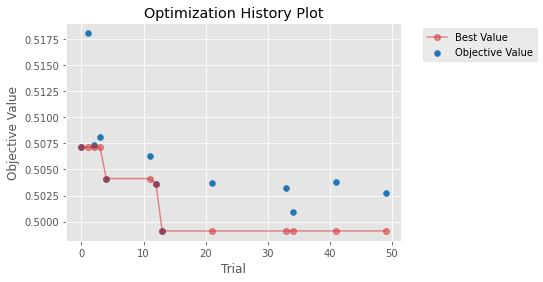

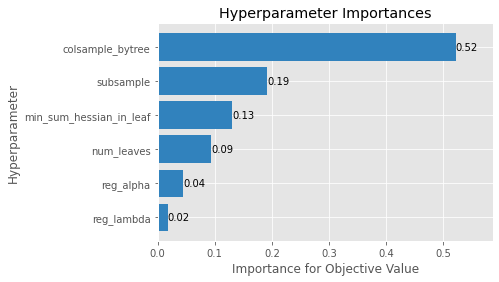

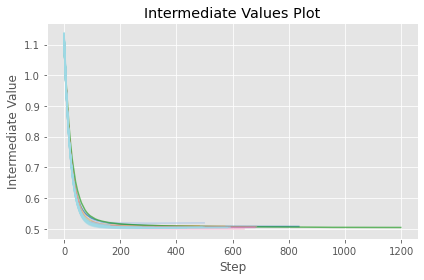

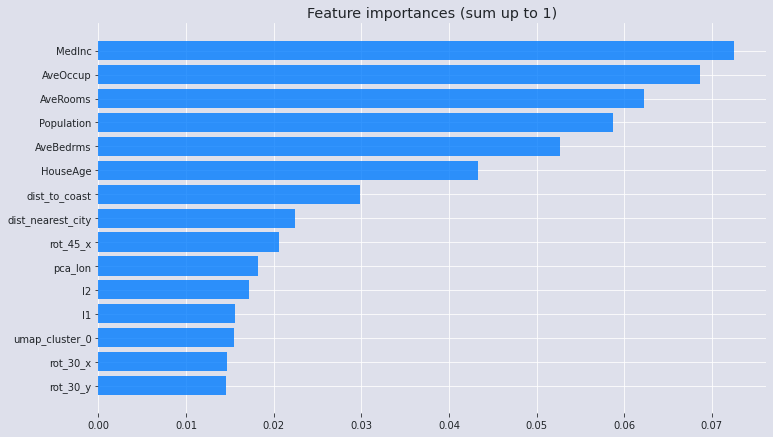


     . Optuna hyperparameters optimization finished
     .. Best trial number:13    |     rmse:          0.49910473315055587
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  389   |     rmse:           0.5141021460420411

Time elapsed for fit execution: 14 min 49.651 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5059134742243139
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5065006164812713
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.507050240134508
 .................................

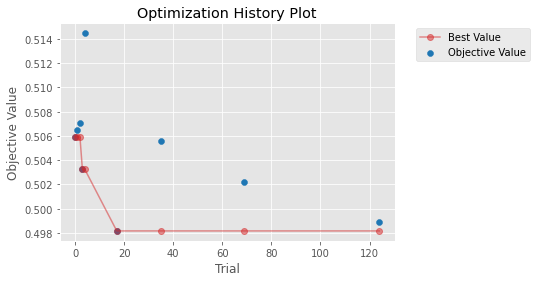

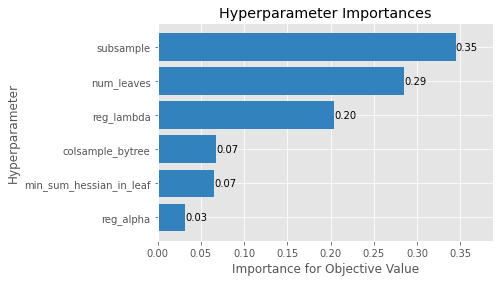

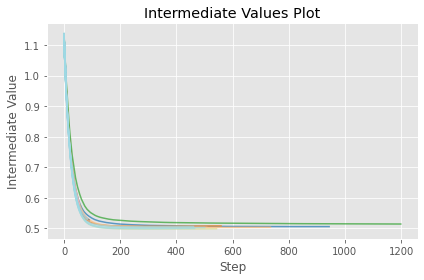

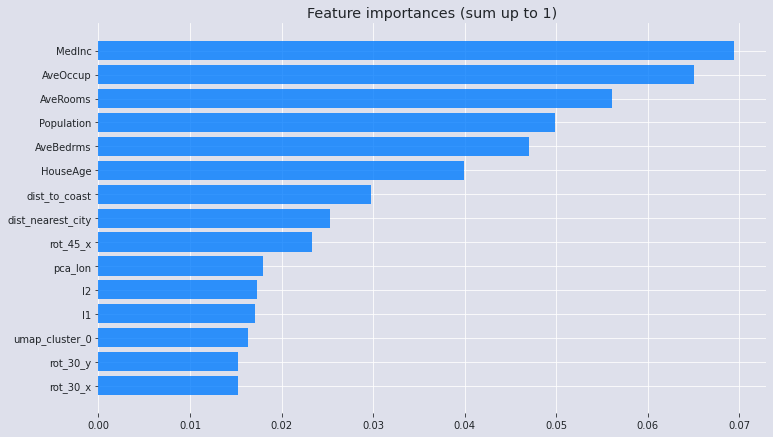


     . Optuna hyperparameters optimization finished
     .. Best trial number:17    |     rmse:           0.4981699712109911
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  322   |     rmse:           0.5141229397826736

Time elapsed for fit execution: 10 min 54.185 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5008429199728955
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5091317516151043
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5071960955904813
 ................................

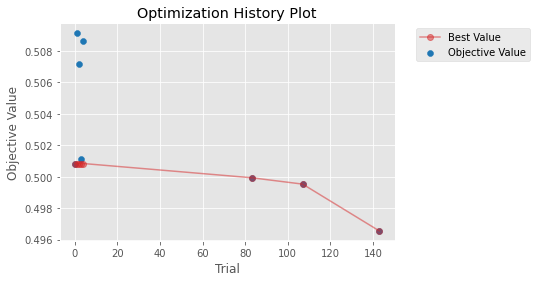

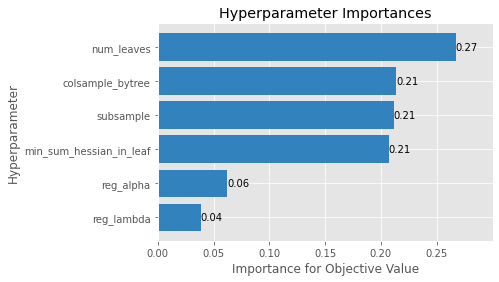

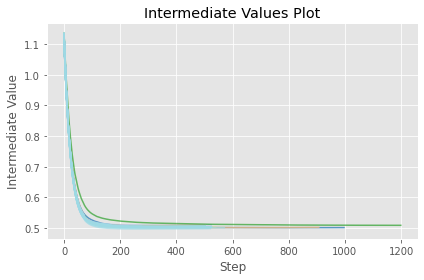

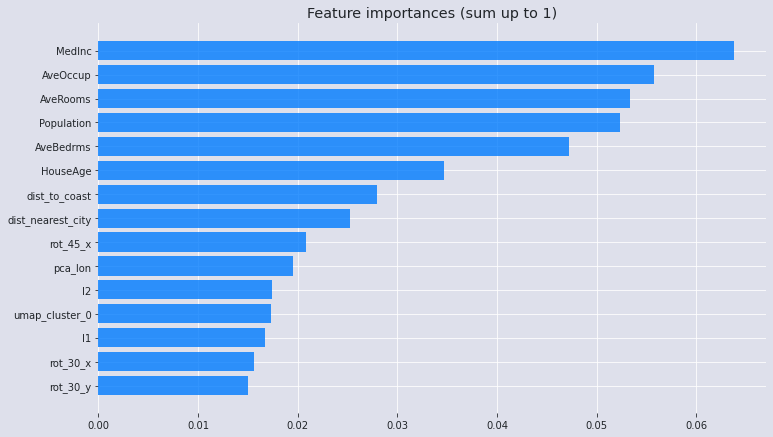


     . Optuna hyperparameters optimization finished
     .. Best trial number:143    |     rmse:          0.49655616782923373
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  348   |     rmse:           0.5126645701330417

Time elapsed for fit execution: 18 min 3.074 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.50440917436242
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5038208569965557
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5140457826317785
 ..................................

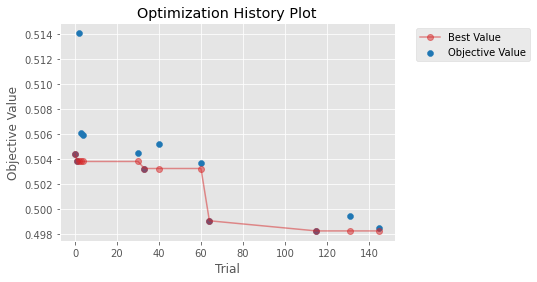

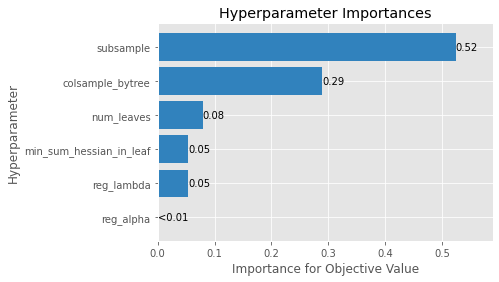

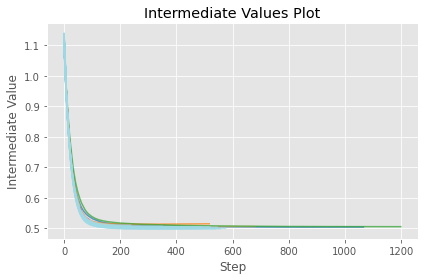

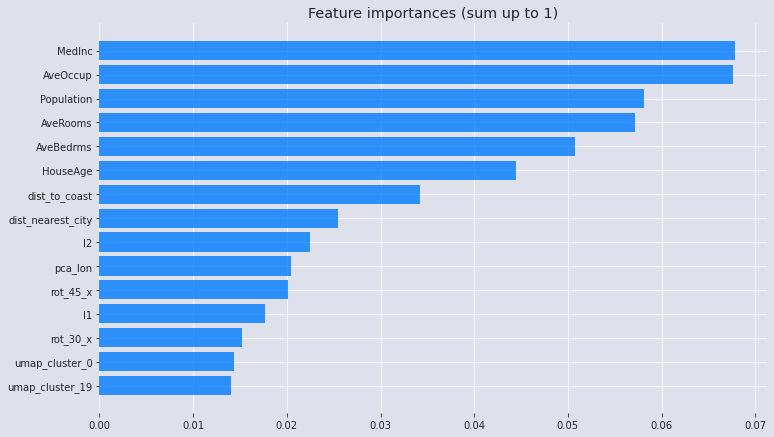


     . Optuna hyperparameters optimization finished
     .. Best trial number:115    |     rmse:          0.49828258465041525
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  349   |     rmse:           0.5171582300886037

Time elapsed for fit execution: 17 min 0.763 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.505030101994977
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5105882822612101
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5049122480673309
 .................................

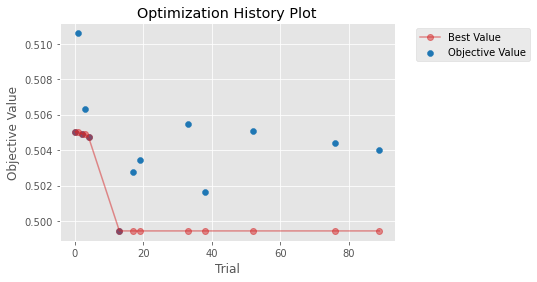

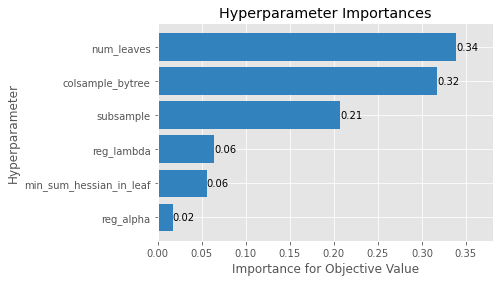

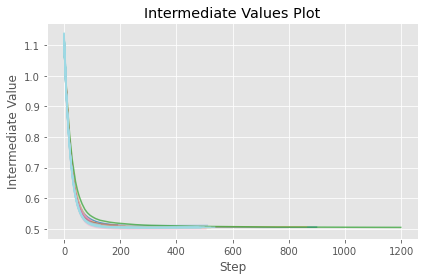

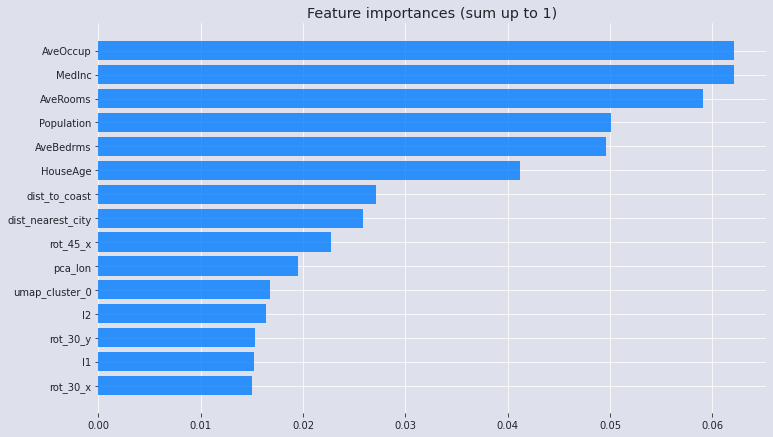


     . Optuna hyperparameters optimization finished
     .. Best trial number:13    |     rmse:           0.4994398868600975
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  283   |     rmse:           0.5145440884842994

Time elapsed for fit execution: 15 min 7.28 sec


In [ ]:
Mean_Prediction, predictions, a = stable_prediction(12, scaled_X, scaled_test)

In [ ]:
pd.DataFrame( Mean_Prediction ).to_csv('non_c3.csv')

### cluster_20 제거

In [ ]:
drop_cols = [f'cluster_20_{i}'for i in range(20)]
scaled_X = scaled_X.drop( drop_cols , axis=1 )
scaled_test = scaled_test.drop( drop_cols , axis=1 )


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5184895519838332
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5059056308133449
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5002075224167616
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 0.5059542572194409
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 0.5113910164980998
 ..............................................

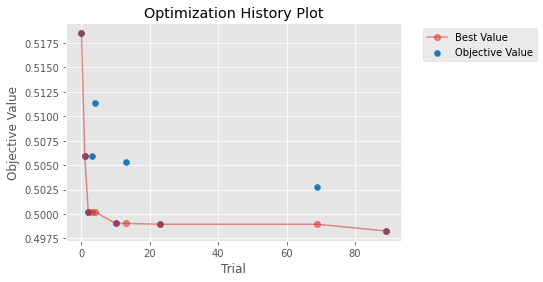

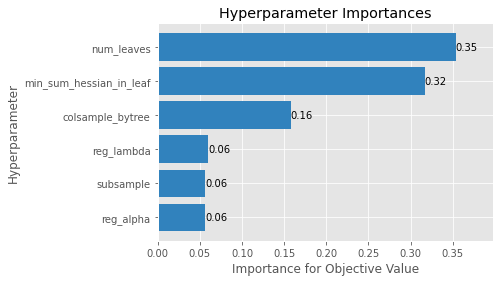

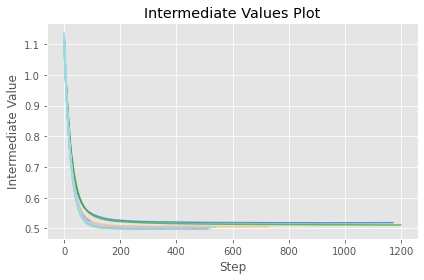

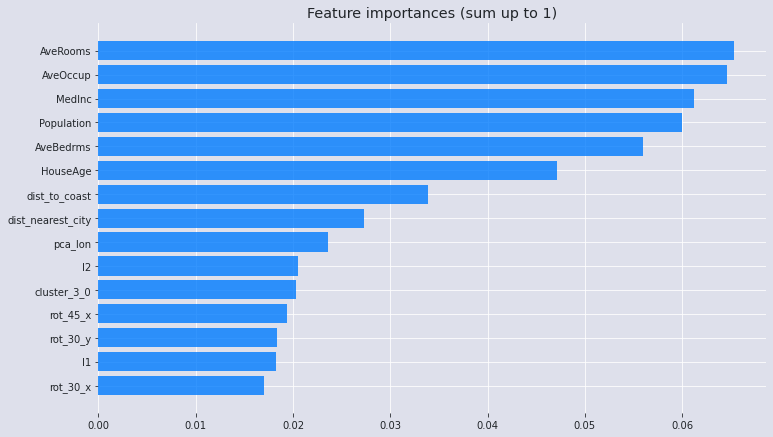


     . Optuna hyperparameters optimization finished
     .. Best trial number:89    |     rmse:          0.49826651928668547
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  326   |     rmse:           0.5152362870316053

Time elapsed for fit execution: 13 min 52.054 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5109765679433428
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5151259920505784
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5128388598225423
 ................................

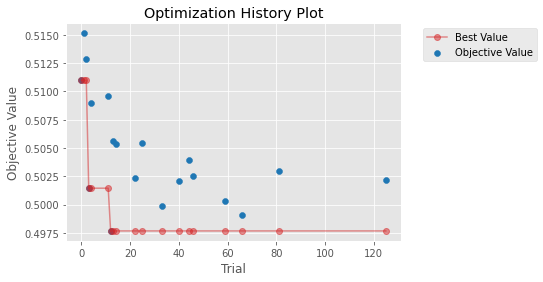

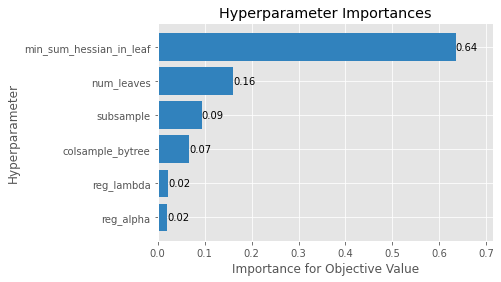

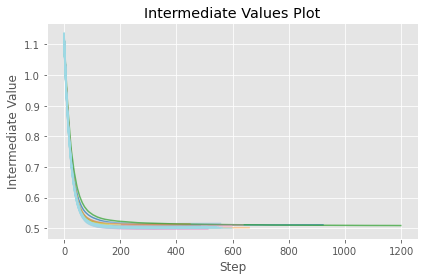

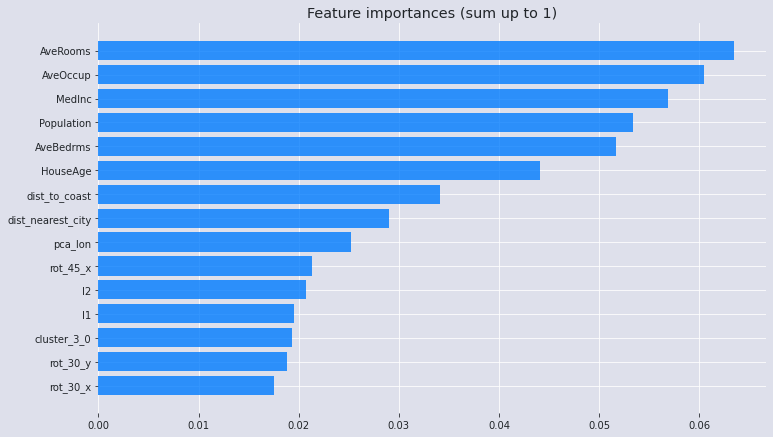


     . Optuna hyperparameters optimization finished
     .. Best trial number:12    |     rmse:           0.4976820323922565
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  348   |     rmse:           0.5144133270622266

Time elapsed for fit execution: 15 min 46.136 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.509401617826981
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5202310367697942
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.507755759976803
 ..................................

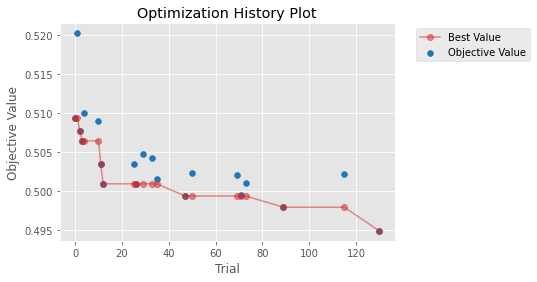

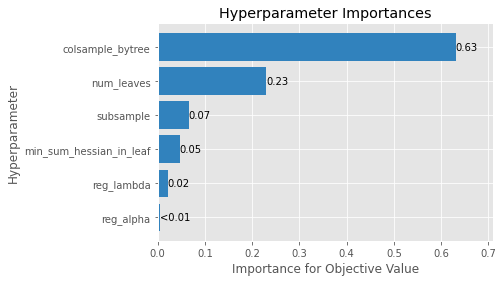

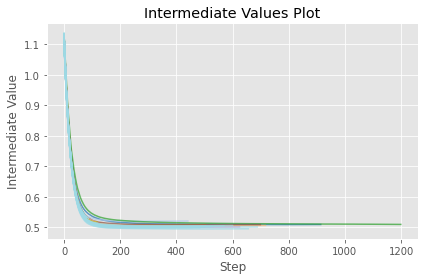

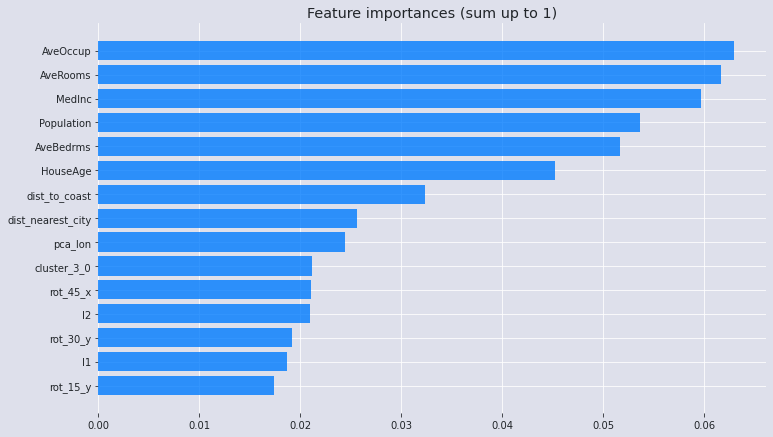


     . Optuna hyperparameters optimization finished
     .. Best trial number:130    |     rmse:          0.49492339491293164
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  366   |     rmse:           0.5136718165174852

Time elapsed for fit execution: 16 min 35.96 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5090522582239999
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.505019296890578
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.4999653913313786
 .................................

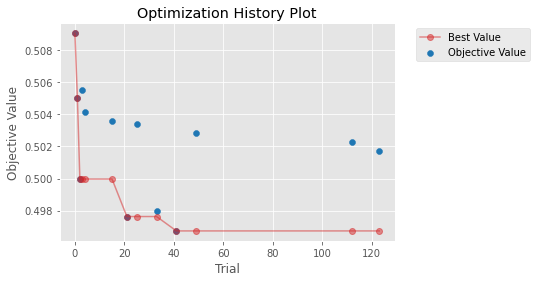

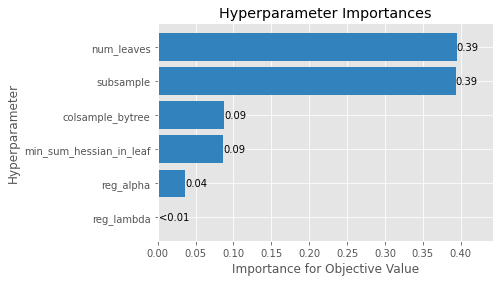

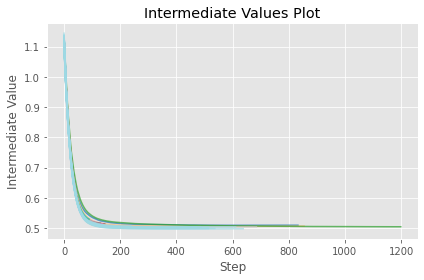

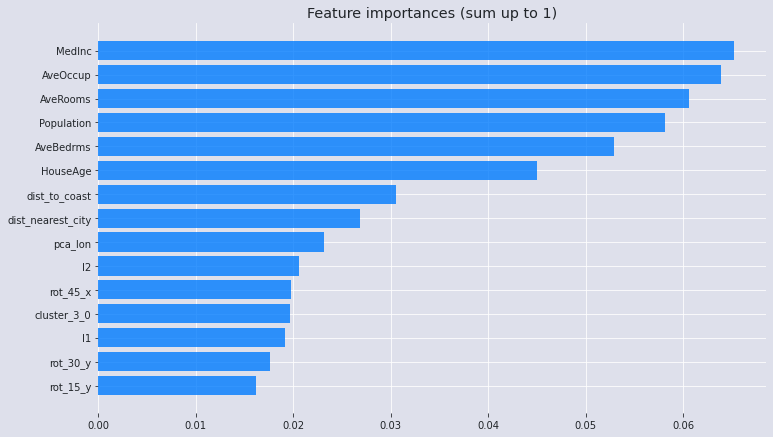


     . Optuna hyperparameters optimization finished
     .. Best trial number:41    |     rmse:           0.4967347619973306
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  492   |     rmse:           0.5131234797926651

Time elapsed for fit execution: 12 min 45.838 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5121088708846636
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5116742821197826
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5039679074401676
 ................................

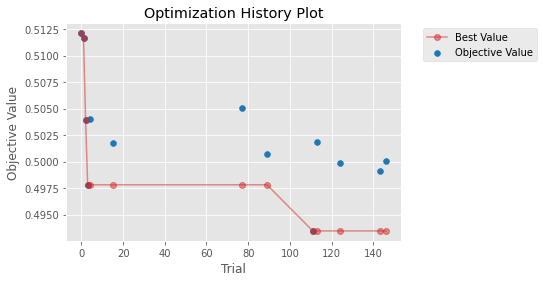

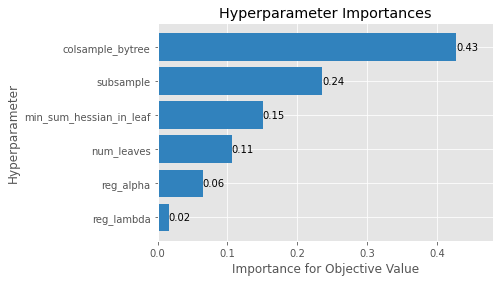

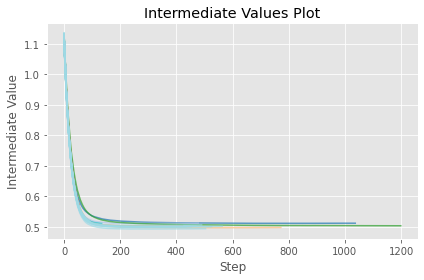

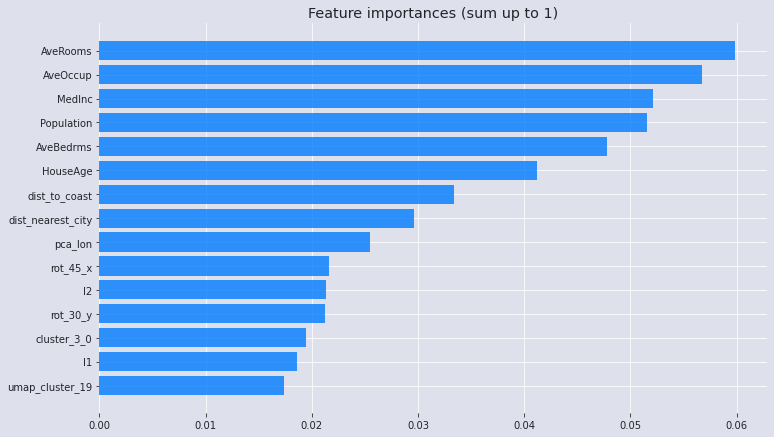


     . Optuna hyperparameters optimization finished
     .. Best trial number:111    |     rmse:          0.49346385580022617
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  288   |     rmse:           0.5139412294339125

Time elapsed for fit execution: 12 min 54.302 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.506944565393398
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5040874200799595
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.513140614520762
 .................................

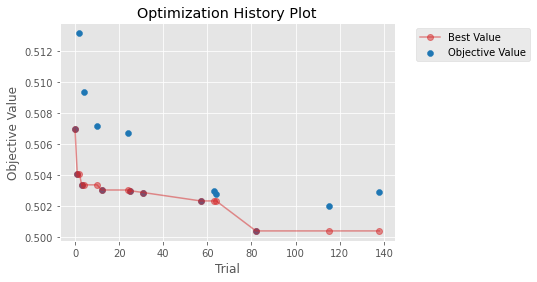

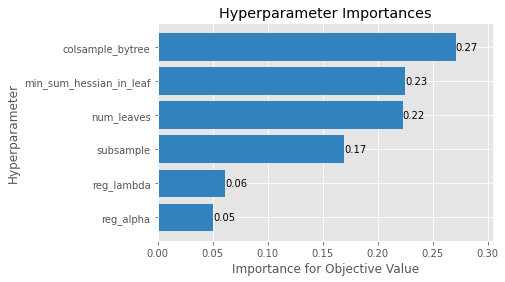

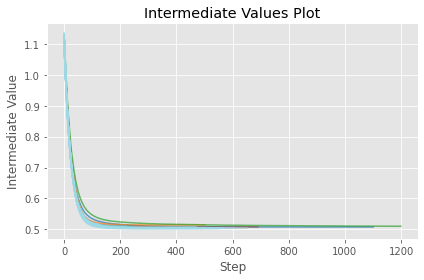

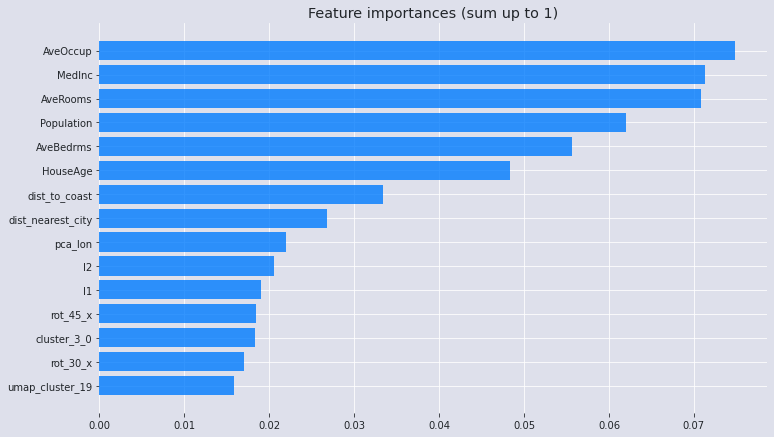


     . Optuna hyperparameters optimization finished
     .. Best trial number:82    |     rmse:           0.5004118887149662
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  350   |     rmse:           0.5169749948823925

Time elapsed for fit execution: 15 min 48.437 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5075916531987112
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5152565863759194
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5133358178363188
 ................................

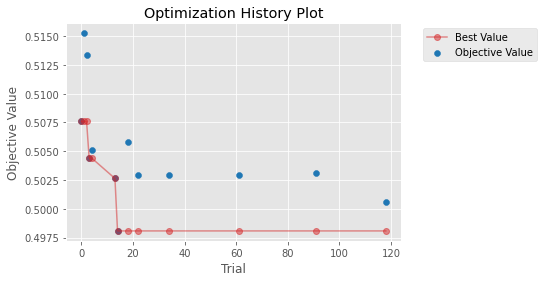

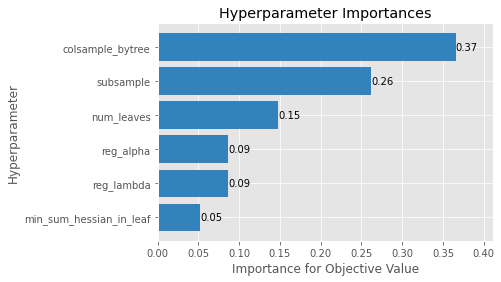

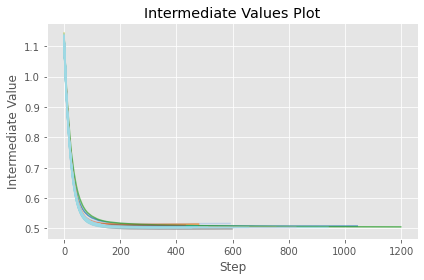

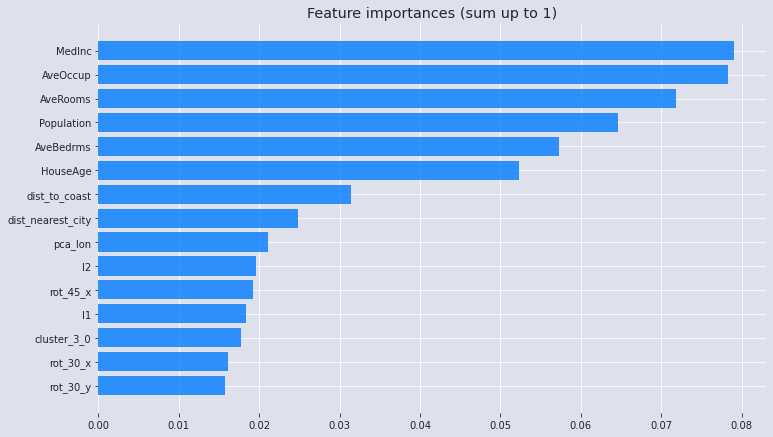


     . Optuna hyperparameters optimization finished
     .. Best trial number:14    |     rmse:           0.4980740394178169
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  520   |     rmse:           0.5158946458597639

Time elapsed for fit execution: 12 min 5.31 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5157305985385665
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5053142985532139
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.506278730362726
 ...................................

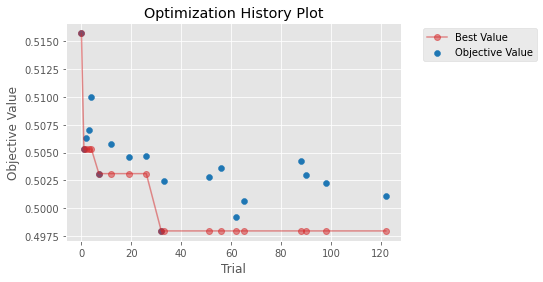

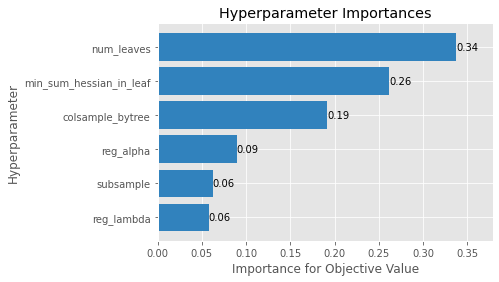

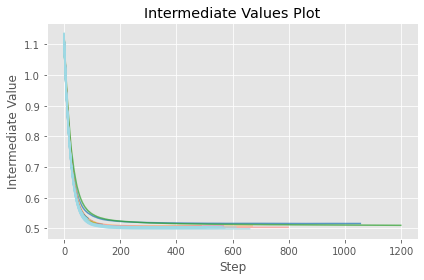

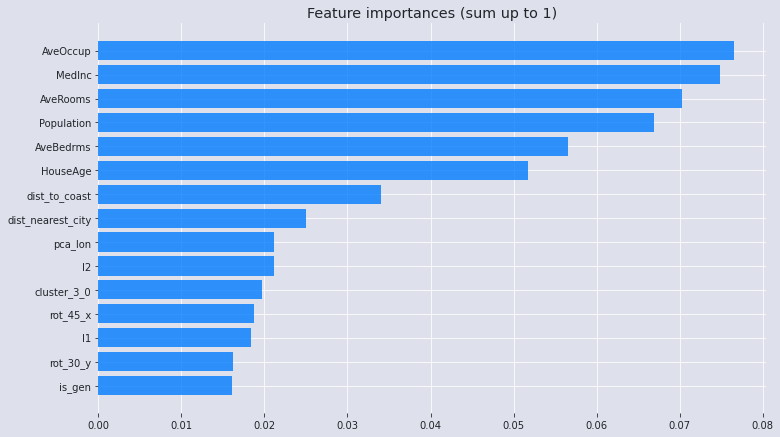


     . Optuna hyperparameters optimization finished
     .. Best trial number:32    |     rmse:          0.49794714810818735
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  356   |     rmse:           0.5164504565296508

Time elapsed for fit execution: 17 min 15.045 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5058366848786032
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5080723054459934
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5074076782029429
 ................................

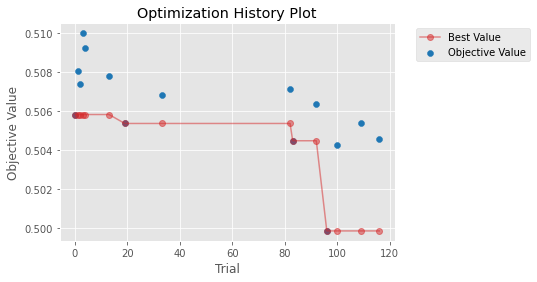

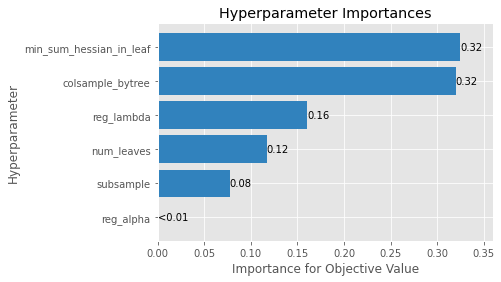

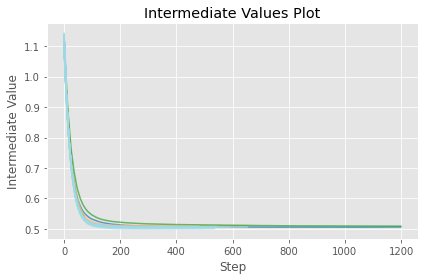

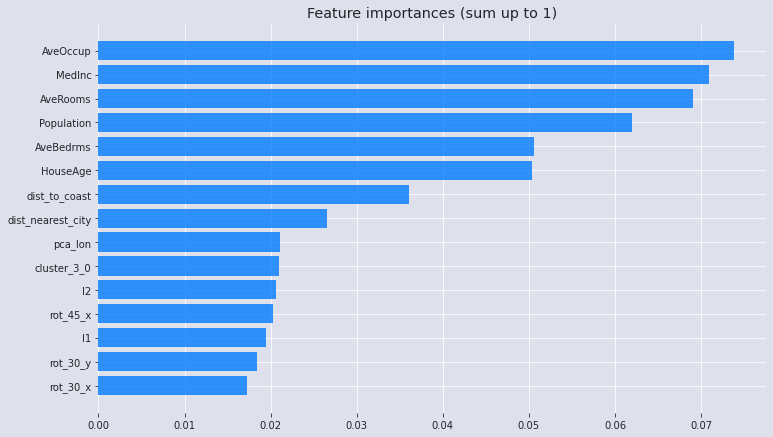


     . Optuna hyperparameters optimization finished
     .. Best trial number:96    |     rmse:          0.49986024524659756
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  286   |     rmse:           0.5177852482620684

Time elapsed for fit execution: 14 min 24.882 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.517136366398865
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5247947645276602
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5076490179952161
 .................................

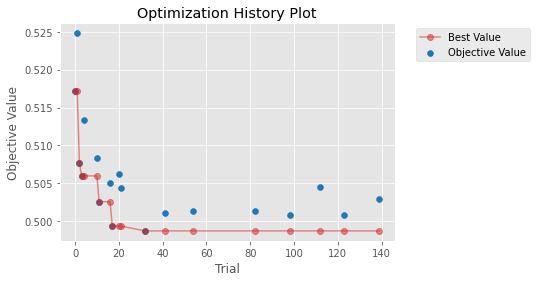

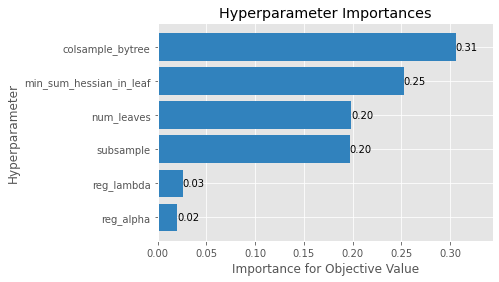

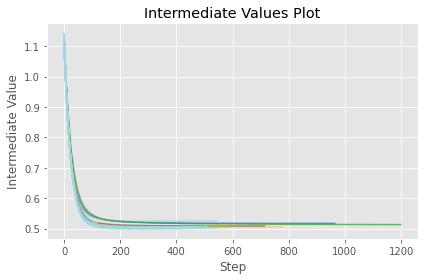

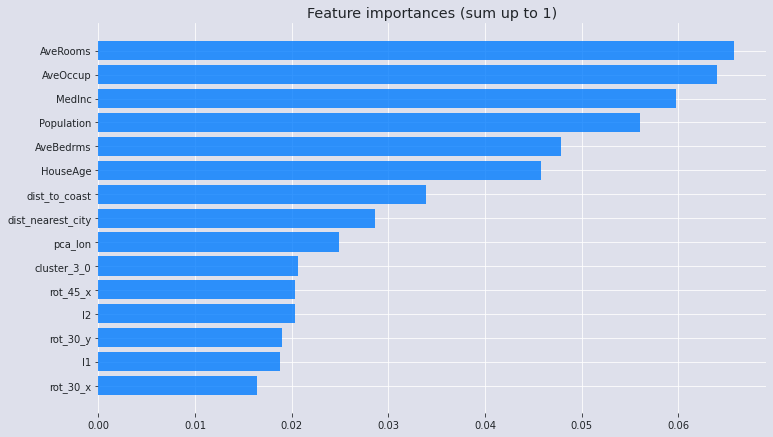


     . Optuna hyperparameters optimization finished
     .. Best trial number:32    |     rmse:           0.4987424403588503
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  307   |     rmse:             0.51349562939426

Time elapsed for fit execution: 14 min 17.263 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5118440429707255
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5151159396307089
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5095179382232462
 ................................

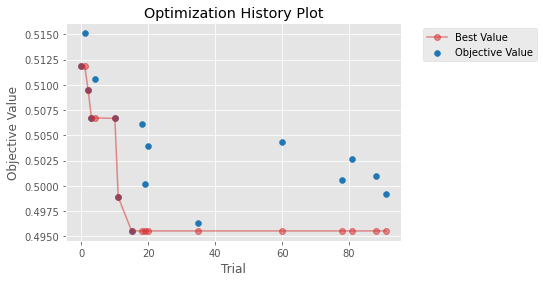

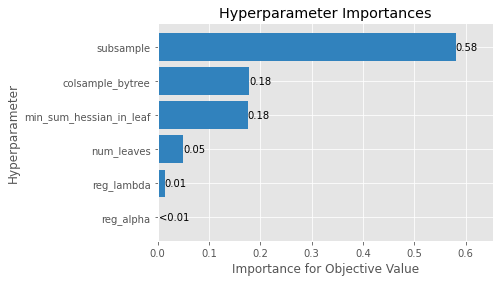

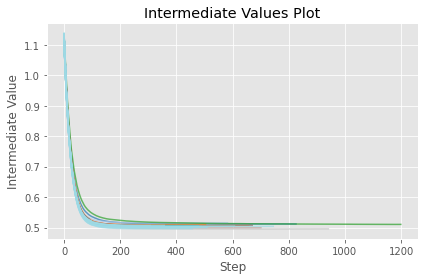

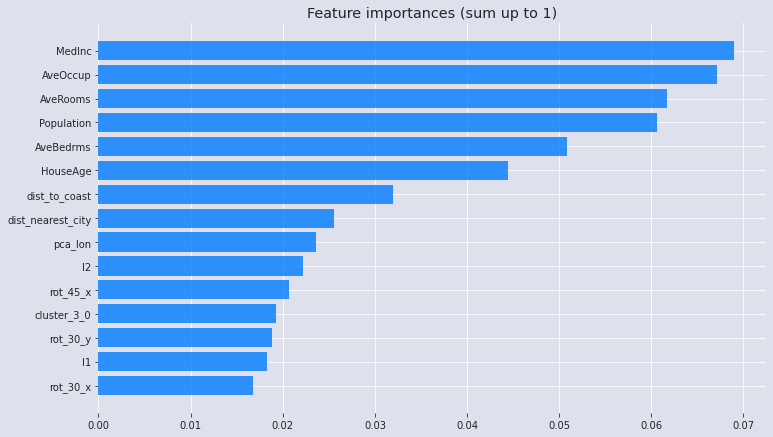


     . Optuna hyperparameters optimization finished
     .. Best trial number:15    |     rmse:           0.4955335854913956
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  427   |     rmse:            0.513627613653184

Time elapsed for fit execution: 14 min 24.624 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5043126490970341
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5084407115910029
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5023344862530165
 ................................

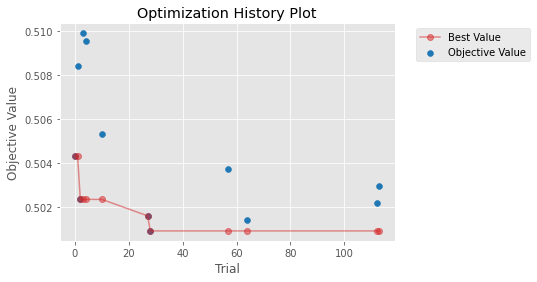

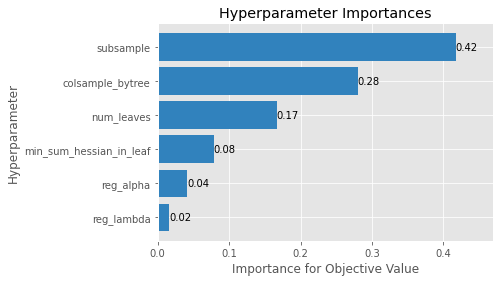

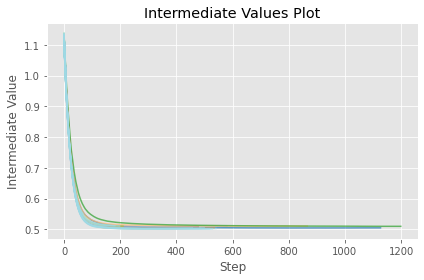

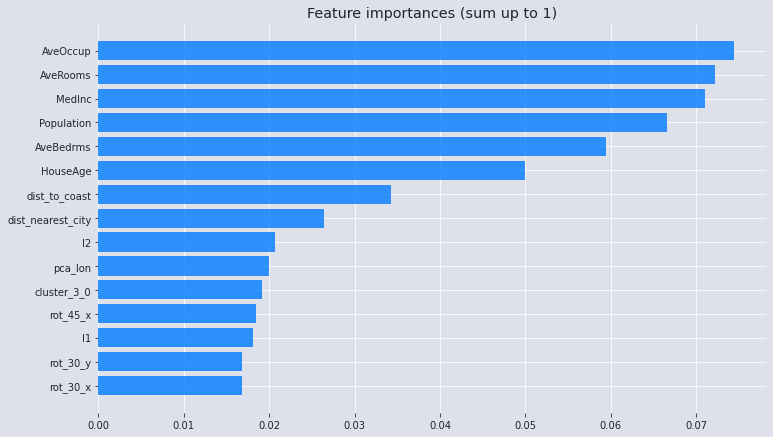


     . Optuna hyperparameters optimization finished
     .. Best trial number:28    |     rmse:           0.5008954146319566
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  347   |     rmse:           0.5171010194295531

Time elapsed for fit execution: 13 min 13.201 sec


In [ ]:
Mean_Prediction, predictions, a = stable_prediction(12, scaled_X, scaled_test)

In [ ]:
pd.DataFrame( Mean_Prediction ).to_csv('non_c20.csv')

# 결론


- umap_cluster피처 제거와, cluster_3피처를 제거해서 나온 각각의 예측값을 블렌딩해서 나온 최종값이 '0.55546'으로 실험 중 가장 높은 결과 값이 나왔다.